# OpenAI Universe part 2: deep q-networks
Last part we used a random search algorithm to "solve" the cartpole environment. This time we are going to take things to the next level and implement a deep q-network.

## Background
Q-learning is a reinforcement learning technique that tries to predict the reward of a state-action pair. For the cartpole environment the state consists of four values, and there are two possible actions. For a certain state S we can predict the reward if we were to push left $Q(S,left)$ or right $Q(S,right)$. 

In the Atari game environment you get a reward of 1 every time you score a point. This scoring can happen when you hit a block in breakout, an alien in Space Invaders, or eat a pallet in Pacman. In the cartpole environment you get a reward every time the pole is standing on the cart (which is: every frame). The trick of q-learning is that it not only considers the direct reward, but also the expected future reward. After applying action $a$ we enter state $S_{t+1}$ and take the following into account: 
- The reward $r$ we obtained by performing this action
- The expected maximum reward $Q(S_{t+1},a)$, in the cartpole environment this is $max(Q(S_{t+1},left), Q(S_{t+1},right)$

We combine this into a neat formula where say that the predicted value should be $r$ in a 

\begin{equation*}
Q(S,a) = \left\{
\begin{array}{ll}
r & \text{for terminal} S_{t+1} \\
r + \gamma max_a Q(S_{t+1},a)& \text{for nonterminal } S_{t+1}
\end{array} \right.
\end{equation*}
Where $\gamma$ is the discount factor. Taking a small $\gamma$ (for example 0.2) means that you don't really care about long-term rewards, a large $\gamma$ (0.95) means that you care a lot about the long-term rewards. In our case we do care a lot about long-term rewards, so we take a large $\gamma$. 

Let's apply our knowledge of q-learning on the same environment we tried last time: the CartPole environment. 


In [1]:
%matplotlib notebook
from time import gmtime, strftime
import threading
import time

import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display
import tensorflow as tf
import gym
from gym import wrappers
import random

from matplotlib import animation
from JSAnimation.IPython_display import display_animation

env = gym.make('CartPole-v0')
observation = env.reset()


[2017-07-03 08:47:42,018] Making new env: CartPole-v0


## Value approximation
There are many ways in which you can estimate the Q-value for each (state,action) pair. The latest "cool" thing to do is estimate it using a neural network. This is also what we will be doing!

We will build our network in Tensorflow: an open-source libary for machine-learning. If you are not familiar with Tensorflow, the most important thing to know is that we will fist build our network, then initialise it and use it. All python variables are "placeholders" in a session. You can find more information on the [Tensorflow homepage](https://www.tensorflow.org/get_started/)

I created a very simple network layout with four inputs (the four variables we observe) and two outputs (either push left or right). I added four fully connected layers: 
- From 4 to 16 variables
- From 16 to 32 variables
- From 32 to 8 variables
- From 8 to 2 variables

Every layer is a dense layer with a RELU nonlinearity except for the last layer as this one has to predict the expected Q-value. 

In [2]:
# Network input
networkstate = tf.placeholder(tf.float32, [None, 4], name="input")
networkaction = tf.placeholder(tf.int32, [None], name="actioninput")
networkreward = tf.placeholder(tf.float32,[None], name="groundtruth_reward")
action_onehot = tf.one_hot(networkaction, 2, name="actiononehot")

# The variable in our network: 
w1 = tf.Variable(tf.random_normal([4,16], stddev=0.35), name="W1")
w2 = tf.Variable(tf.random_normal([16,32], stddev=0.35), name="W2")
w3 = tf.Variable(tf.random_normal([32,8], stddev=0.35), name="W3")
w4 = tf.Variable(tf.random_normal([8,2], stddev=0.35), name="W4")
b1 = tf.Variable(tf.zeros([16]), name="B1")
b2 = tf.Variable(tf.zeros([32]), name="B2")
b3 = tf.Variable(tf.zeros([8]), name="B3")
b4 = tf.Variable(tf.zeros(2), name="B4")

# The network layout
layer1 = tf.nn.relu(tf.add(tf.matmul(networkstate,w1), b1), name="Result1")
layer2 = tf.nn.relu(tf.add(tf.matmul(layer1,w2), b2), name="Result2")
layer3 = tf.nn.relu(tf.add(tf.matmul(layer2,w3), b3), name="Result3")
predictedreward = tf.add(tf.matmul(layer3,w4), b4, name="predictedReward")

# Learning 
qreward = tf.reduce_sum(tf.multiply(predictedreward, action_onehot), reduction_indices = 1)
loss = tf.reduce_mean(tf.square(networkreward - qreward))
tf.summary.scalar('loss', loss)
optimizer = tf.train.RMSPropOptimizer(0.0001).minimize(loss)
merged_summary = tf.summary.merge_all()


## Session management and Tensorboard

Now we start the session. I added support for Tensorboard: a nice tool to visualise your learning. At the moment I only added one summary: the loss of the network. 
If you did not install Docker yet, make sure [you do this](https://docs.docker.com/engine/installation/#supported-platforms). To run tensorboard you have to run:

```
docker run -p 6006:6006 -v $(pwd):/mounted rmeertens/tensorboard
```

Then navigate to localhost:6006 to see your tensorboard.


In [ ]:
sess = tf.InteractiveSession()
summary_writer = tf.summary.FileWriter('trainsummary',sess.graph)
sess.run(tf.global_variables_initializer())

## Learning Q(S,a)
An interesting paper you can use as guideline for deep q-networks is "Playing Atari with Deep Reinforcement Learning (https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf). This paper by deepmind explains how they were able to teach a neural network to play Atari games. 

One of the main contributions of this paper is their use of an "experience replay mechanism". If you were to train your neural network in the order of images you see normally the network quickly forgets what it saw before. To fix this we save what we saw in a memory with the following variables: 

($S$, $action$, $reward$, $is terminal$, $S_{t+1}$)

Now every frame we sample a random minibatch of our memory and train our network on that. We also only keep the newer experiences to keep our memory fresh with good actions. The full algorithm in their paper looks like this: 
![dqn algorith](dqn alg.png)


In [5]:
replay_memory = [] # (state, action, reward, terminalstate, state_t+1)
epsilon = 1.0
BATCH_SIZE = 32
GAMMA = 0.9
MAX_LEN_REPLAY_MEMORY = 30000
FRAMES_TO_PLAY = 300001
MIN_FRAMES_FOR_LEARNING = 1000

for i_epoch in range(FRAMES_TO_PLAY):
    
    ### Select an action and perform this
    ### EXERCISE: this is where your network should play and try to come as far as possible!
    ### You have to implement epsilon-annealing yourself
    action = env.action_space.sample() 
    newobservation, reward, terminal, info = env.step(action)

    ### I prefer that my agent gets 0 reward if it dies
    if terminal: 
        reward = 0
        
    ### Add the observation to our replay memory
    replay_memory.append((observation, action, reward, terminal, newobservation))
    
    ### Reset the environment if the agent died
    if terminal: 
        newobservation = env.reset()
    observation = newobservation
    
    ### Learn once we have enough frames to start learning
    if len(replay_memory) > MIN_FRAMES_FOR_LEARNING: 
        experiences = random.sample(replay_memory, BATCH_SIZE)
        totrain = [] # (state, action, delayed_reward)
        
        ### Calculate the predicted reward
        nextstates = [var[4] for var in experiences]
        pred_reward = sess.run(predictedreward, feed_dict={networkstate:nextstates})
        
        ### Set the "ground truth": the value our network has to predict:
        for index in range(BATCH_SIZE):
            state, action, reward, terminalstate, newstate = experiences[index]
            predicted_reward = max(pred_reward[index])
            
            if terminalstate:
                delayedreward = reward
            else:
                delayedreward = reward + GAMMA*predicted_reward
            totrain.append((state, action, delayedreward))
            
        ### Feed the train batch to the algorithm 
        states = [var[0] for var in totrain]
        actions = [var[1] for var in totrain]
        rewards = [var[2] for var in totrain]
        _, l, summary = sess.run([optimizer, loss, merged_summary], feed_dict={networkstate:states, networkaction: actions, networkreward: rewards})
        
        
    ### If our memory is too big: remove the first element
    if len(replay_memory) > MAX_LEN_REPLAY_MEMORY:
        replay_memory = replay_memory[1:]

    ### Show the progress in tensorboard and the terminal
    if i_epoch%100==1:
        summary_writer.add_summary(summary, i_epoch)
    if i_epoch%1000==1:
        print("Epoch %d, loss: %f" % (i_epoch,l))

Epoch 1001, loss: 1.113190
Epoch 2001, loss: 1.659957
Epoch 3001, loss: 5.381553
Epoch 4001, loss: 0.618028
Epoch 5001, loss: 11.600357
Epoch 6001, loss: 5.476669
Epoch 7001, loss: 6.104239
Epoch 8001, loss: 2.464887
Epoch 9001, loss: 5.424720
Epoch 10001, loss: 1.951883
Epoch 11001, loss: 0.955659
Epoch 12001, loss: 2.136605
Epoch 13001, loss: 3.630434
Epoch 14001, loss: 1.484200
Epoch 15001, loss: 1.575967
Epoch 16001, loss: 0.182232
Epoch 17001, loss: 0.156421
Epoch 18001, loss: 0.717424
Epoch 19001, loss: 0.149184
Epoch 20001, loss: 0.074543
Epoch 21001, loss: 0.152463
Epoch 22001, loss: 1.014114
Epoch 23001, loss: 0.313165
Epoch 24001, loss: 0.100253
Epoch 25001, loss: 0.132337
Epoch 26001, loss: 2.114637
Epoch 27001, loss: 0.076322
Epoch 28001, loss: 0.684142
Epoch 29001, loss: 0.253772
Epoch 30001, loss: 0.136145
Epoch 31001, loss: 0.076565
Epoch 32001, loss: 0.133033
Epoch 33001, loss: 0.102335
Epoch 34001, loss: 0.249565
Epoch 35001, loss: 0.354738
Epoch 36001, loss: 0.265936


## Testing the algorithm
Now we have a trained network that gives use the expected $Q(s,a)$ for a certain state. We can use this to balance the stick (and see how long it lasts) and see what the network predicts at each frame:



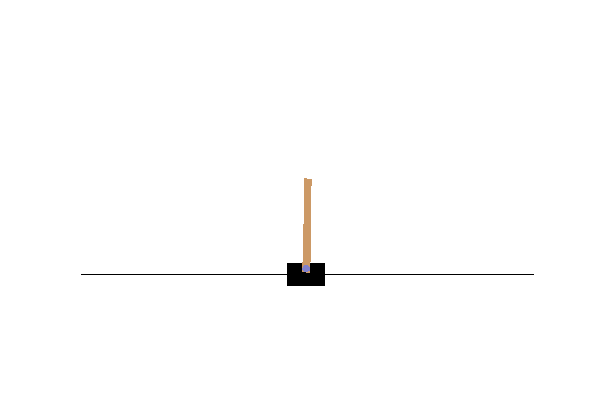
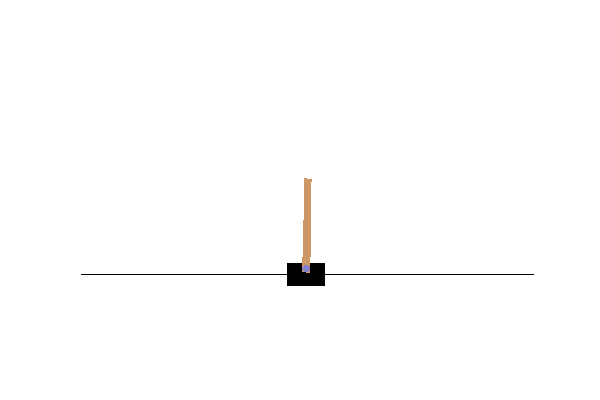
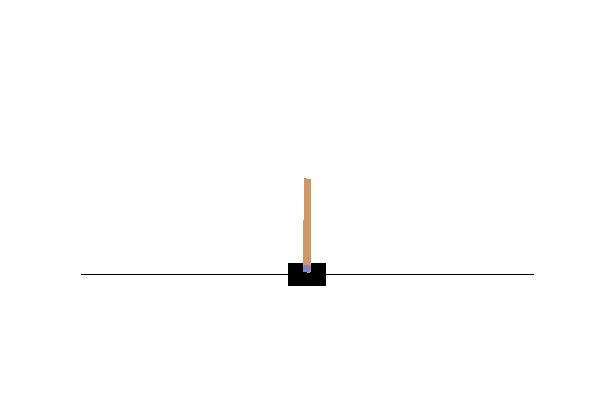
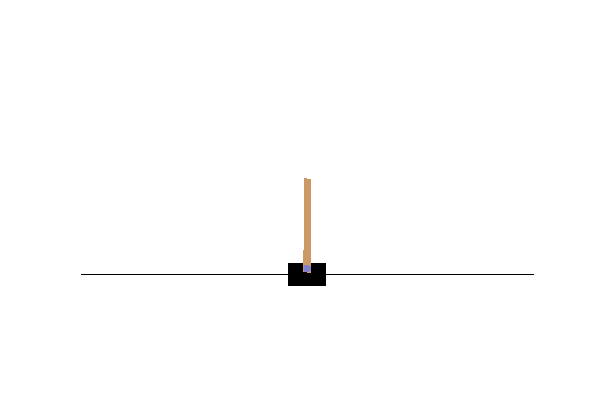
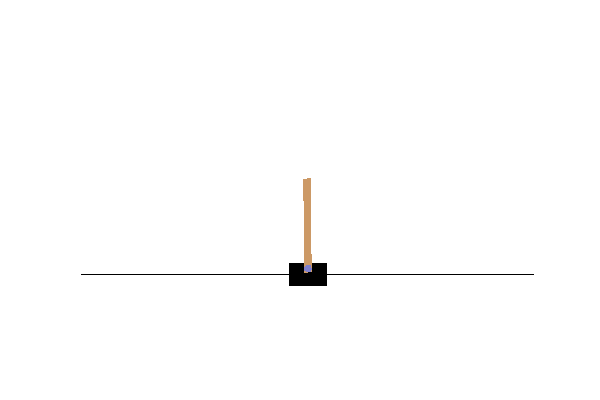
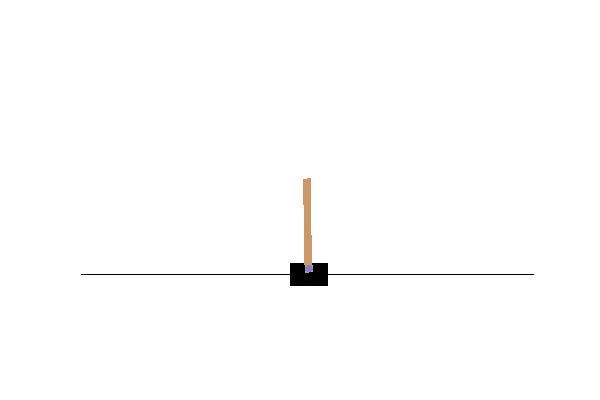
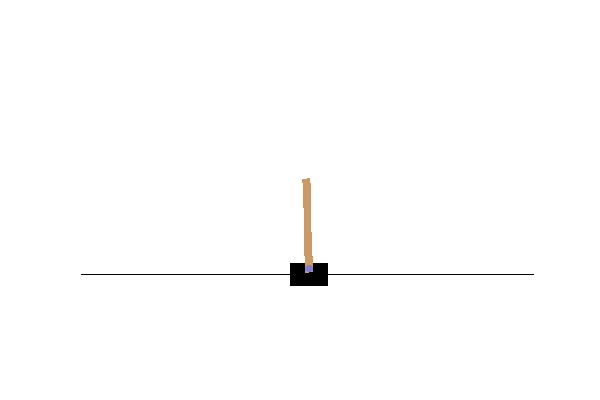
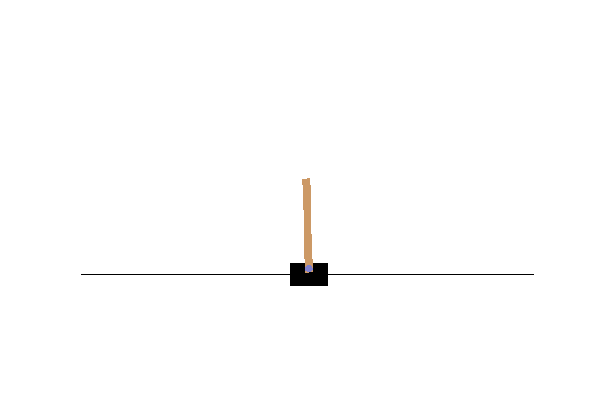
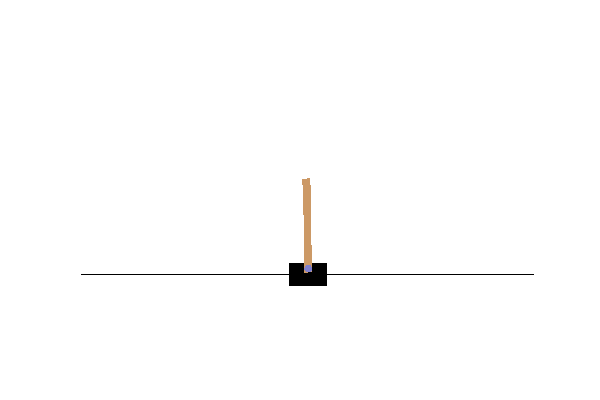
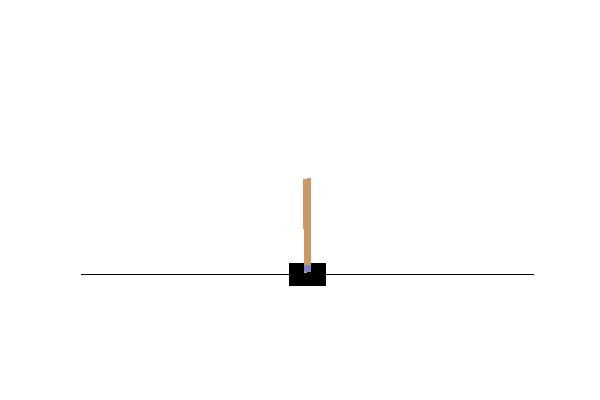
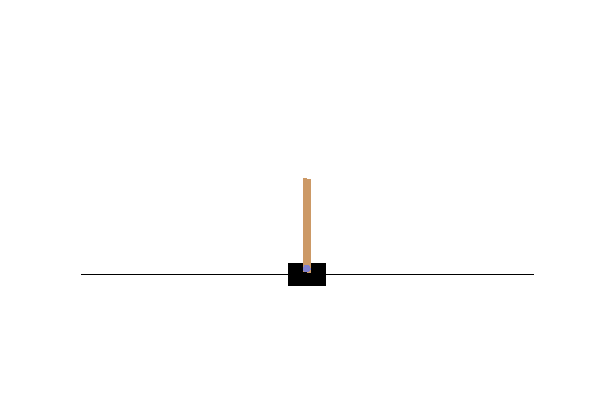
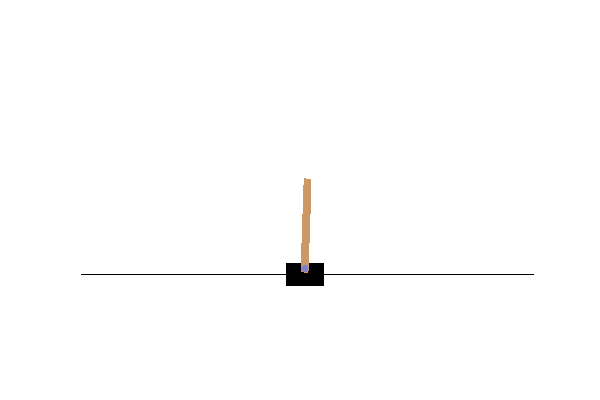
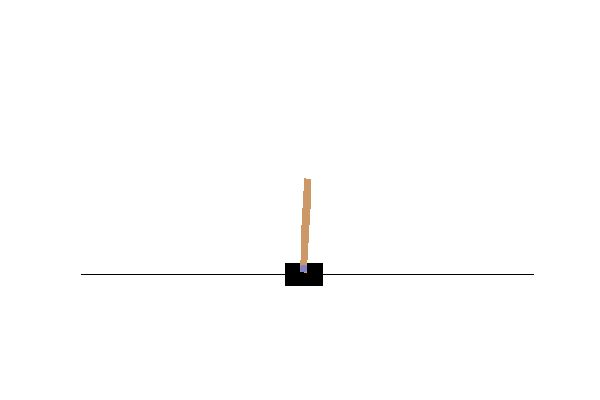
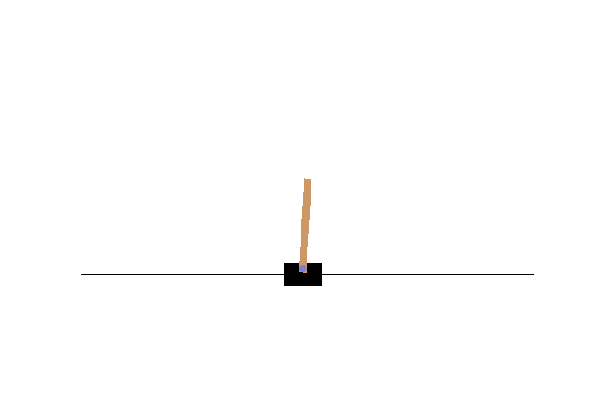
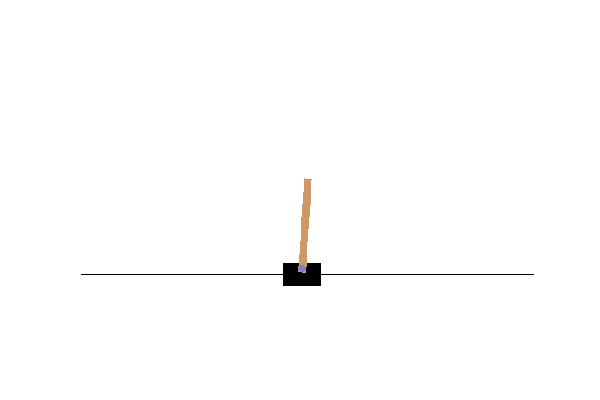
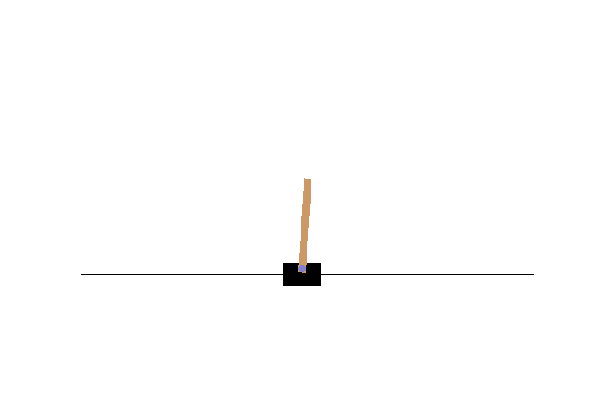
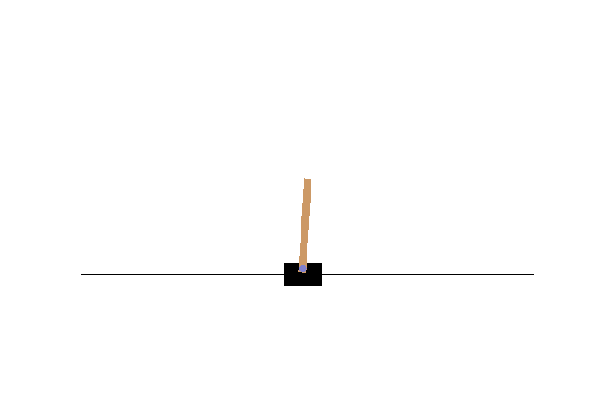
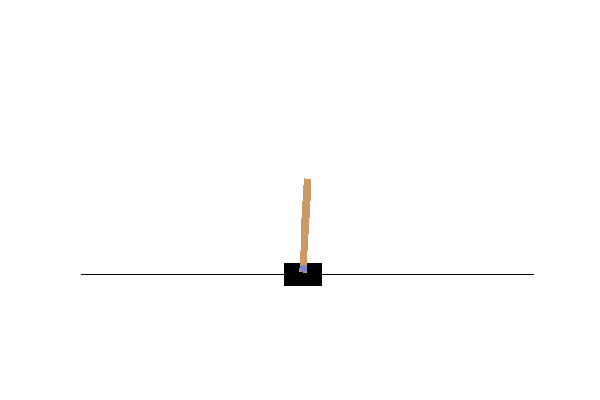
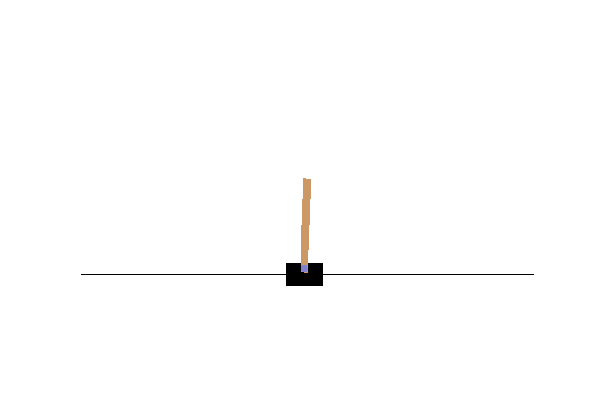
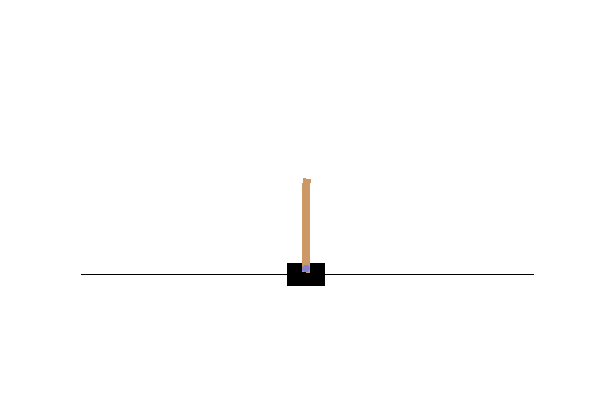
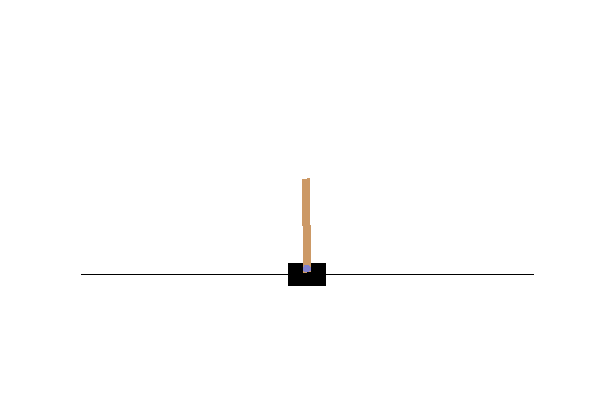
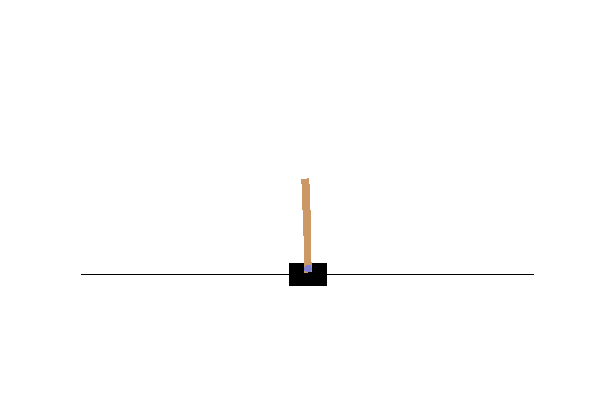
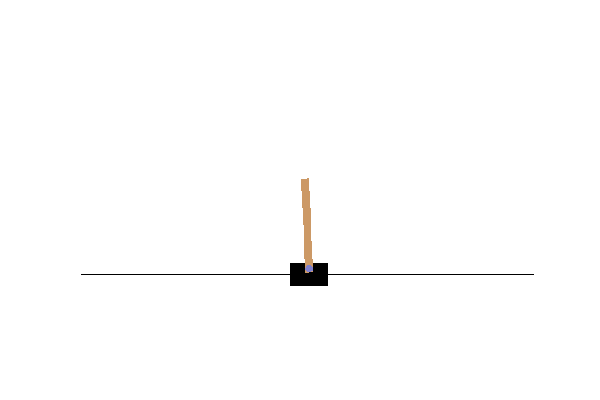
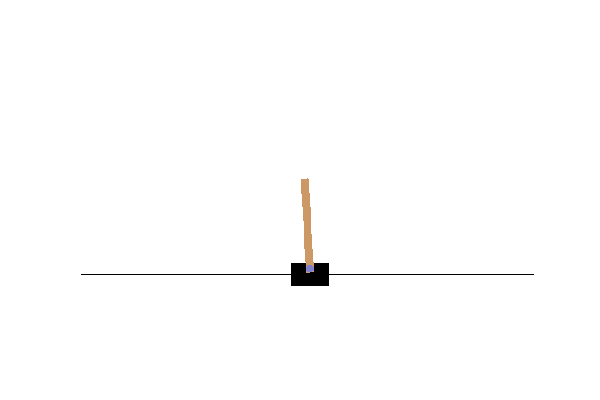
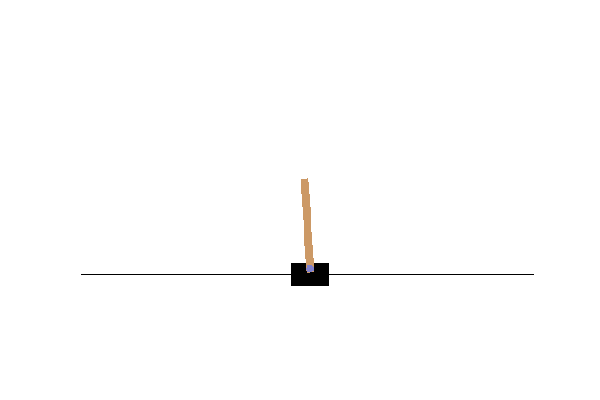
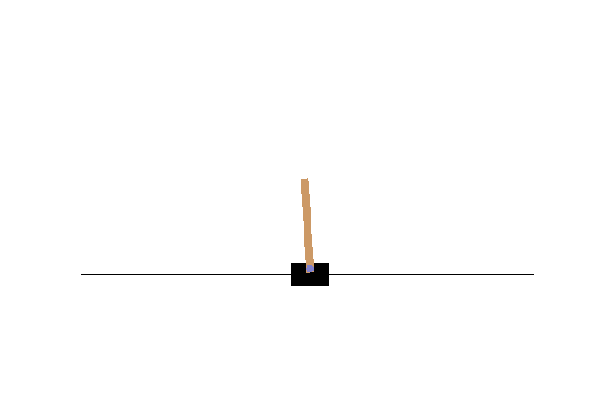
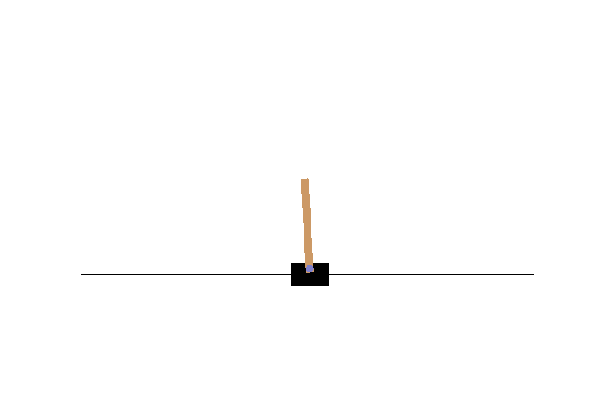
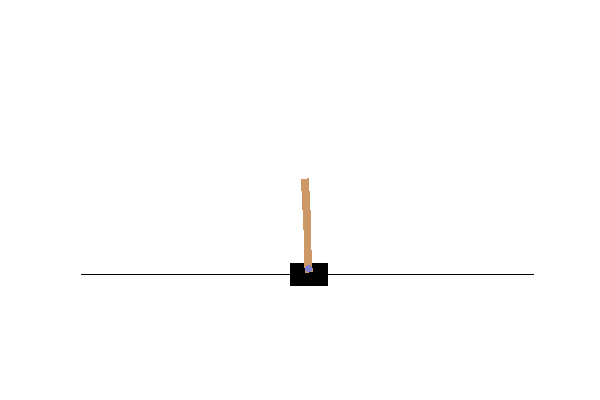
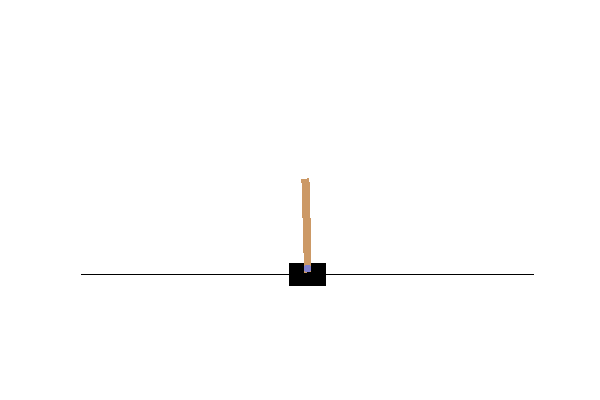
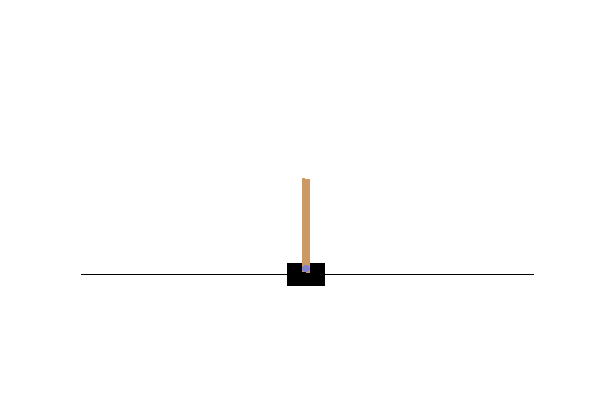
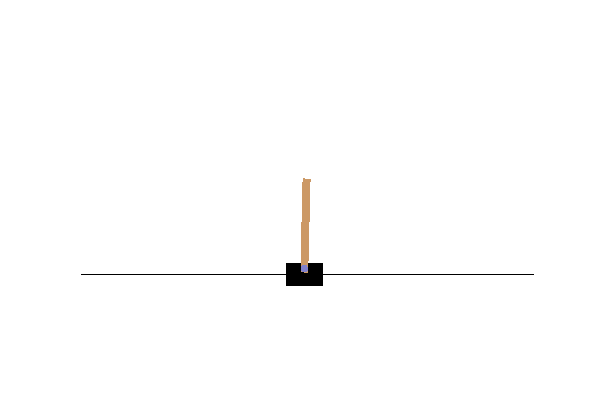
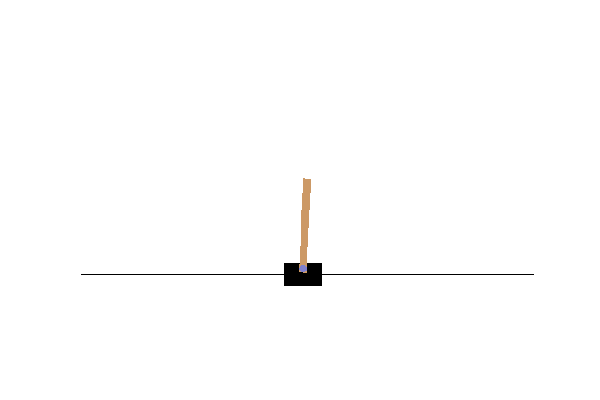
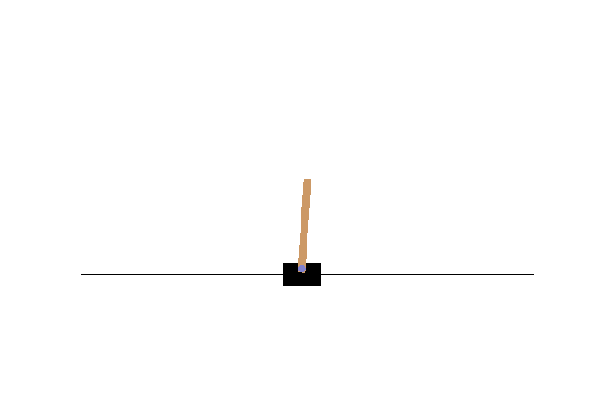
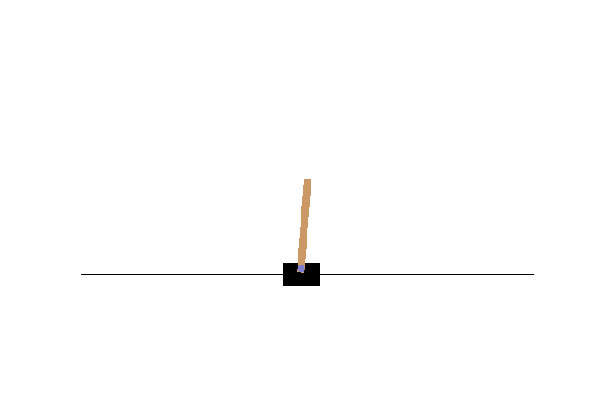
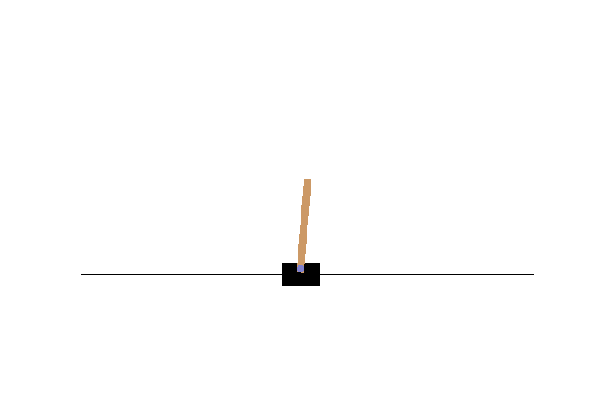
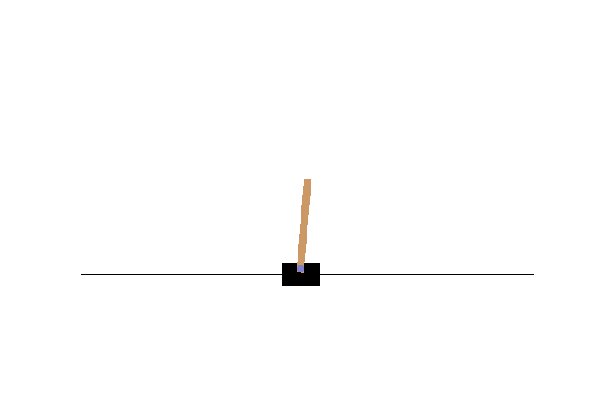
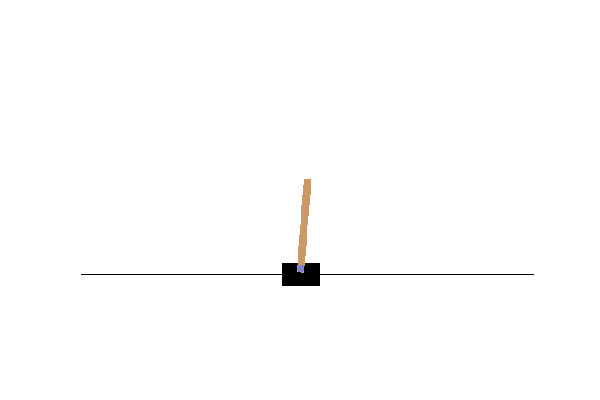
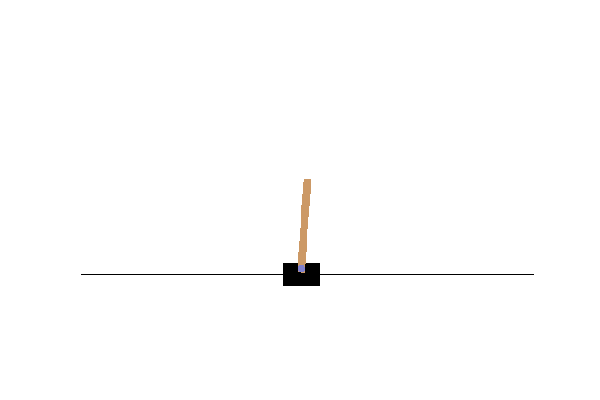
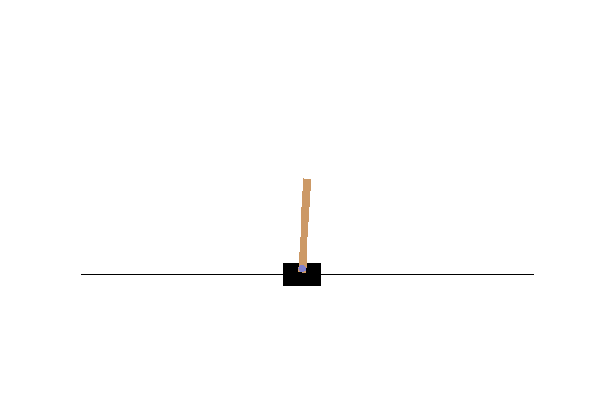
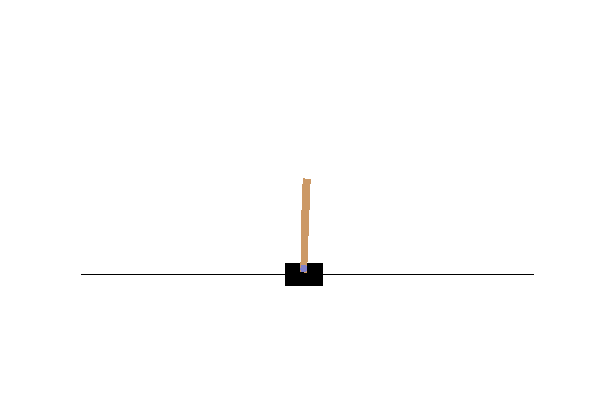
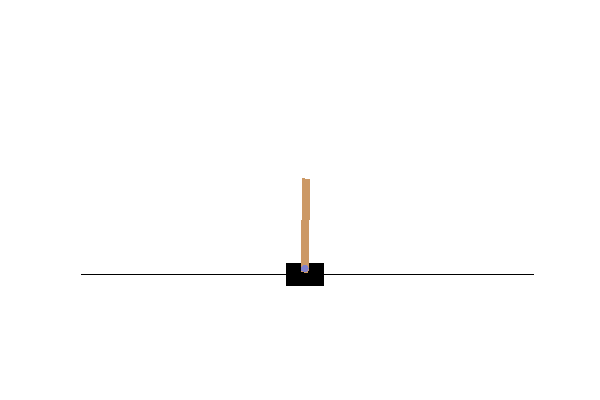
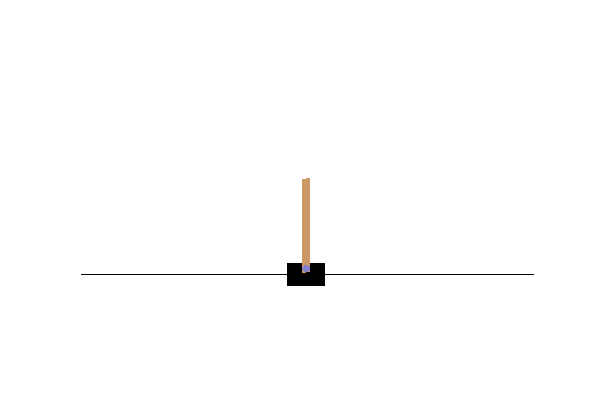
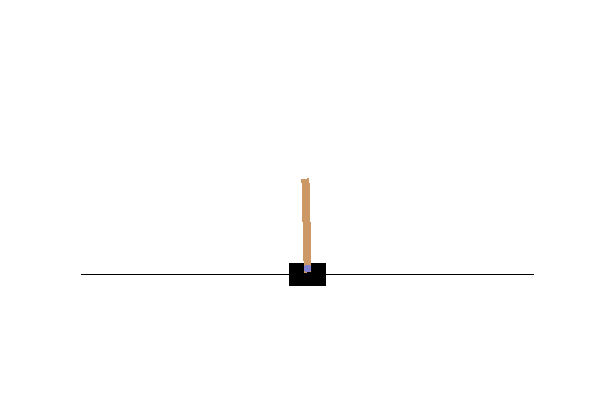
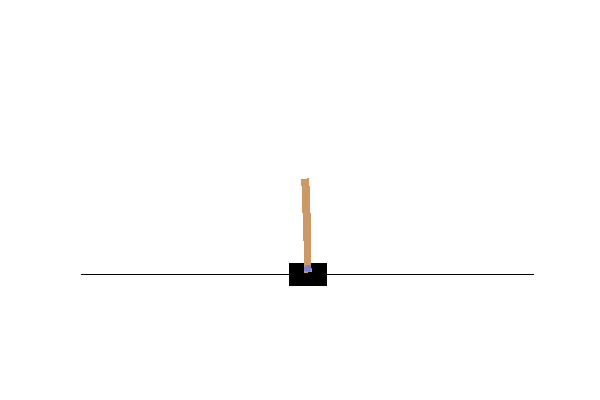
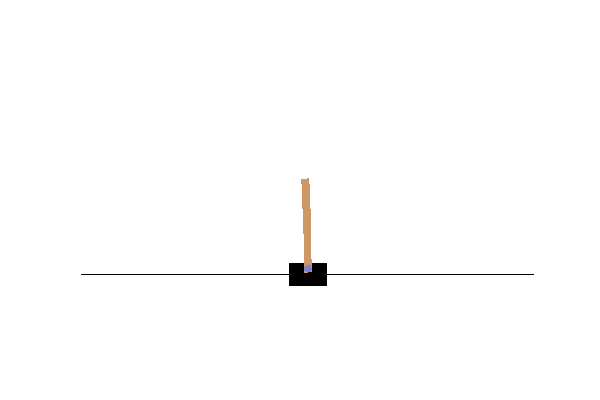
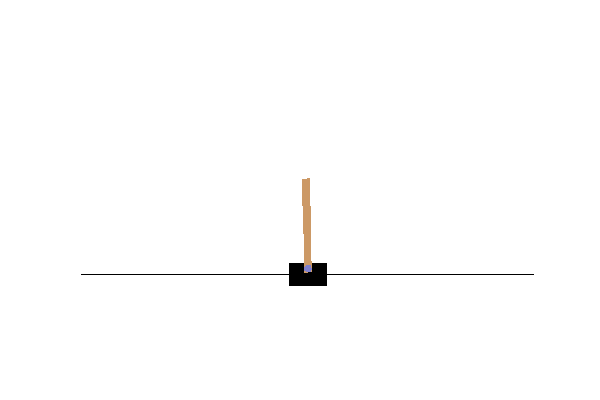
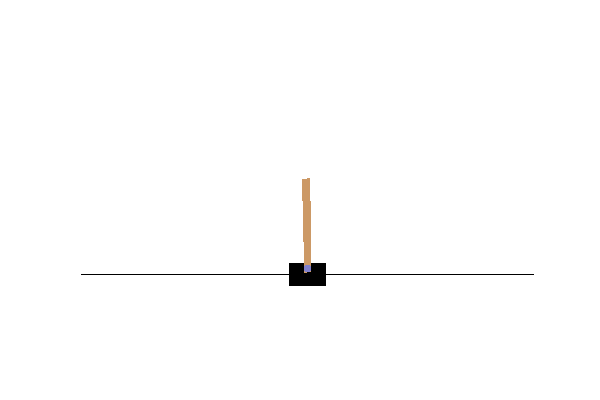
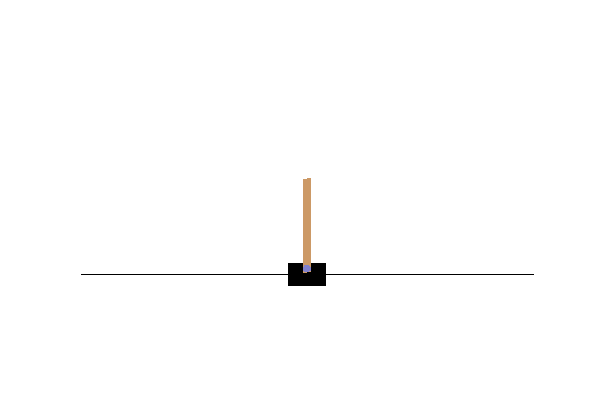
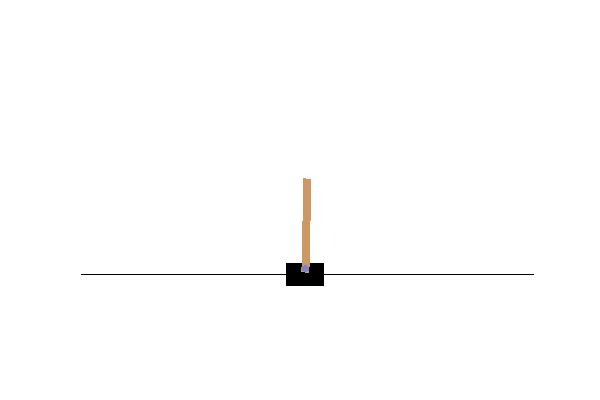
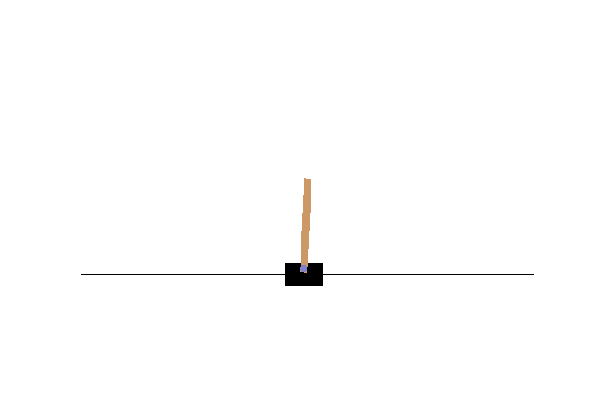
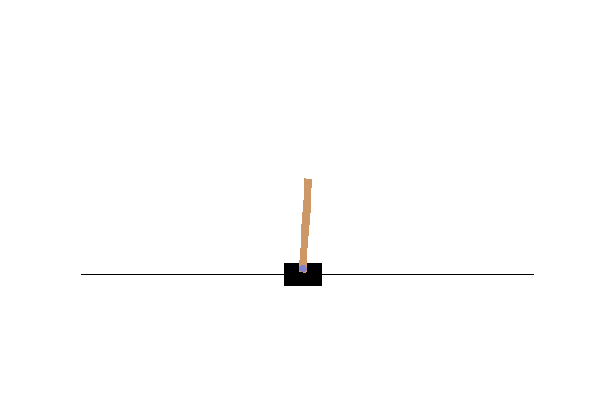
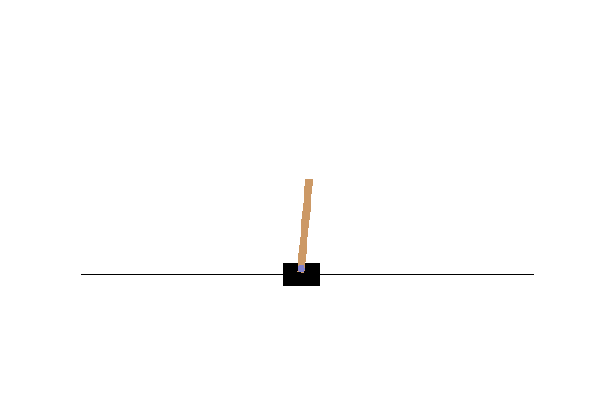
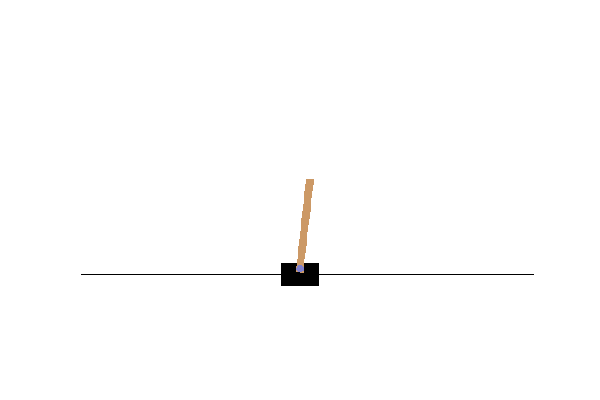
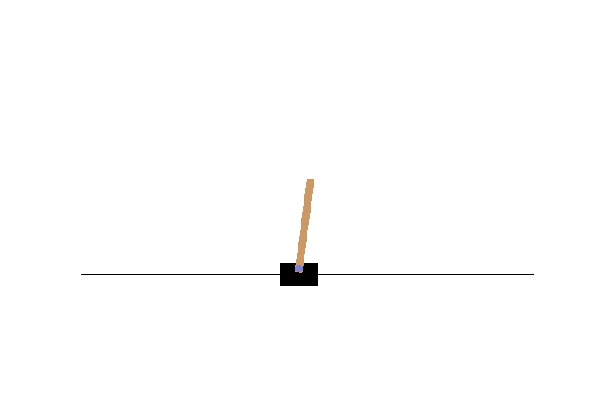
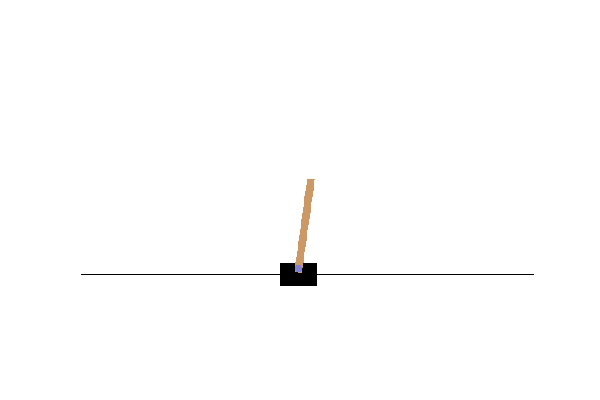
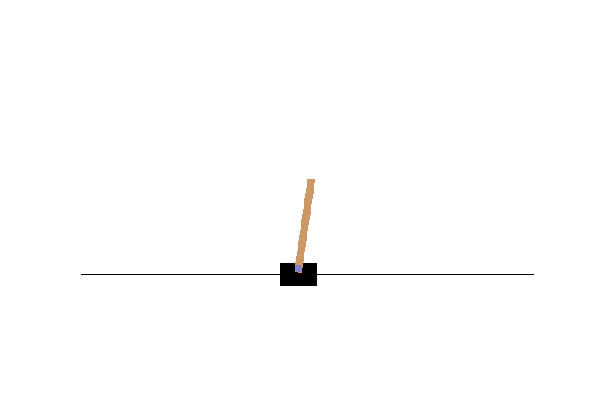
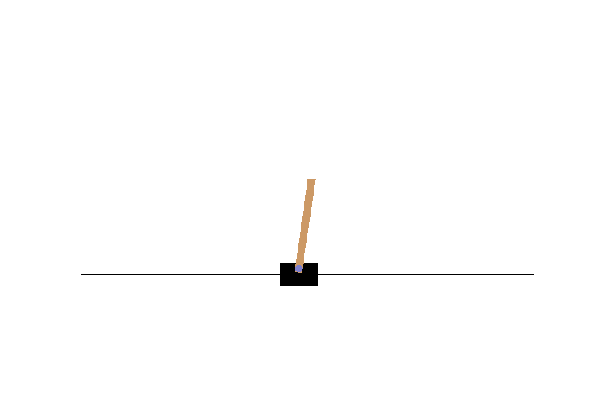
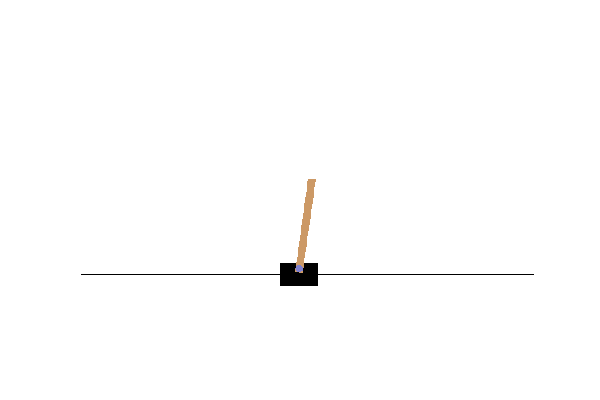
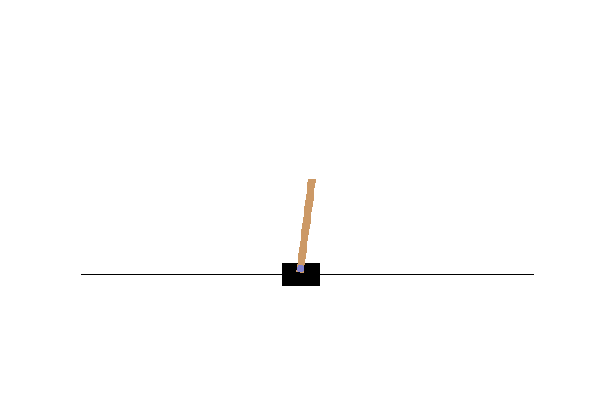
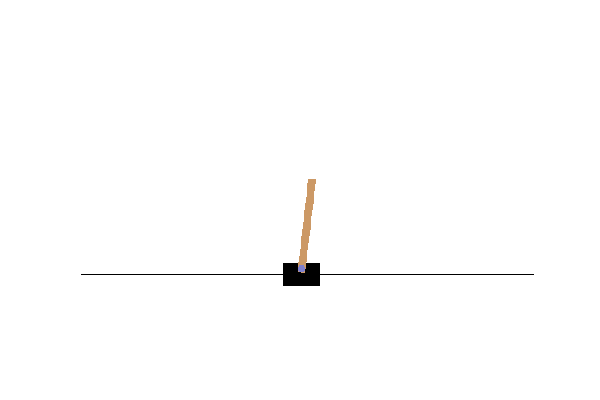
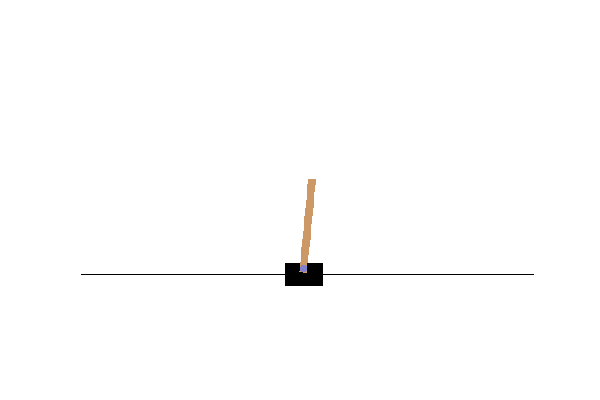
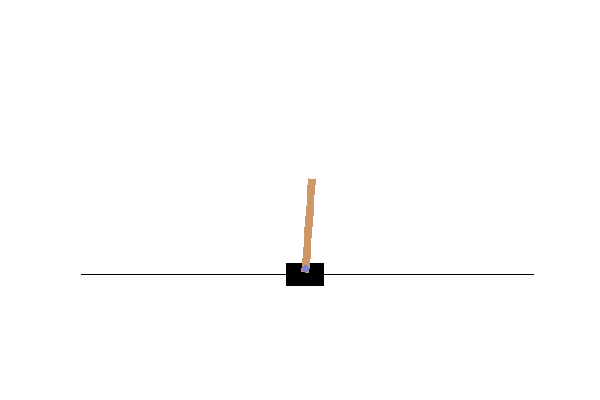
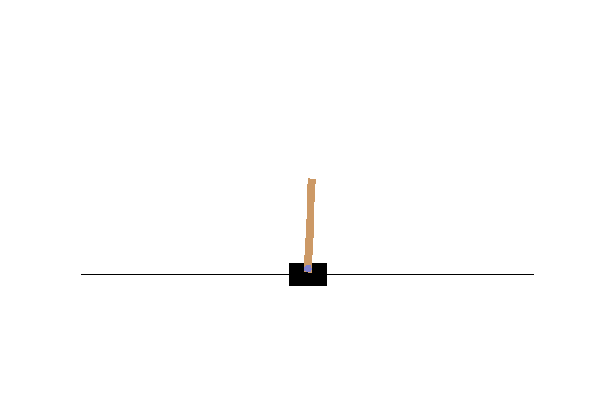
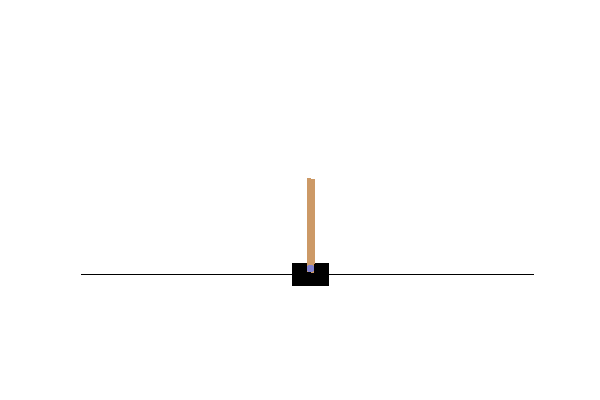
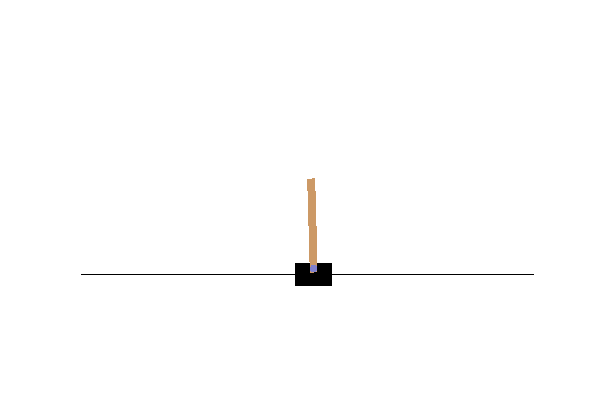
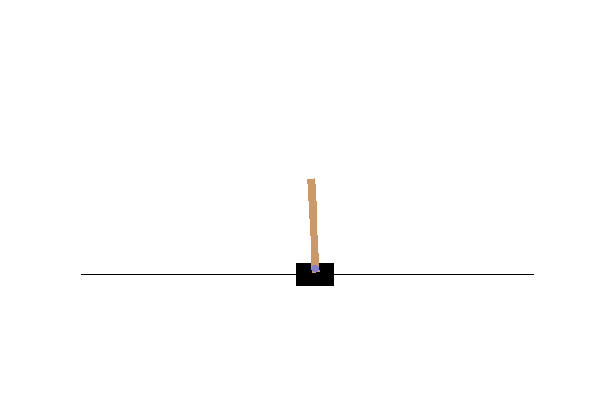
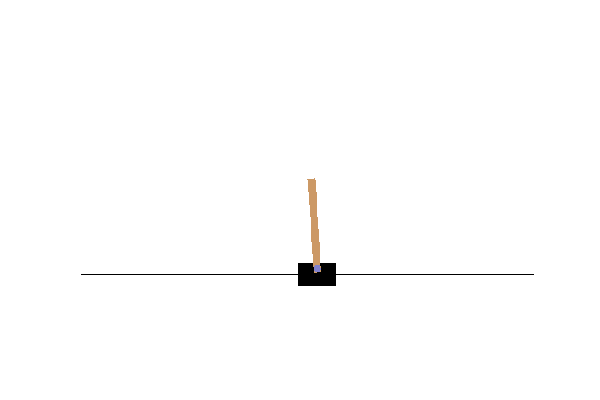
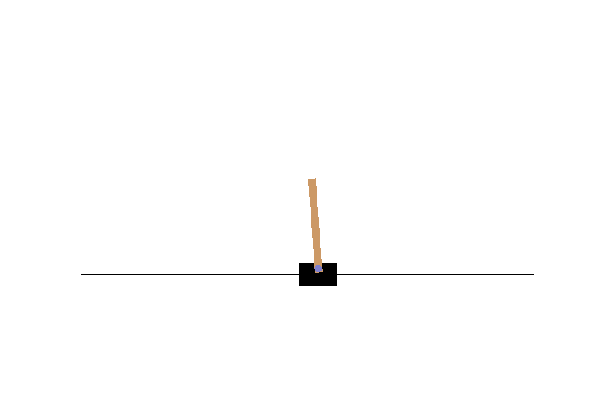
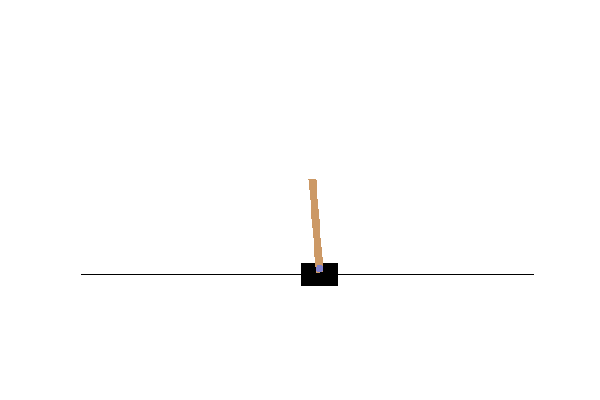
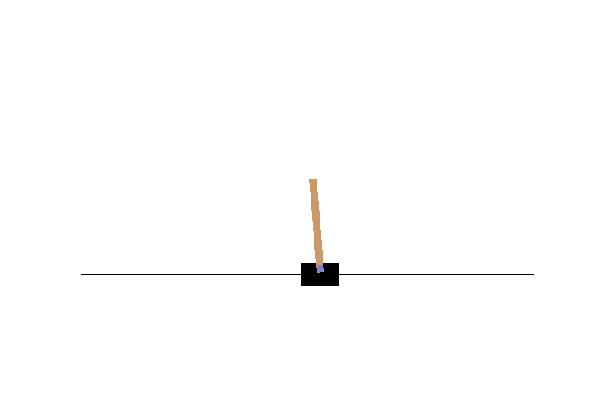
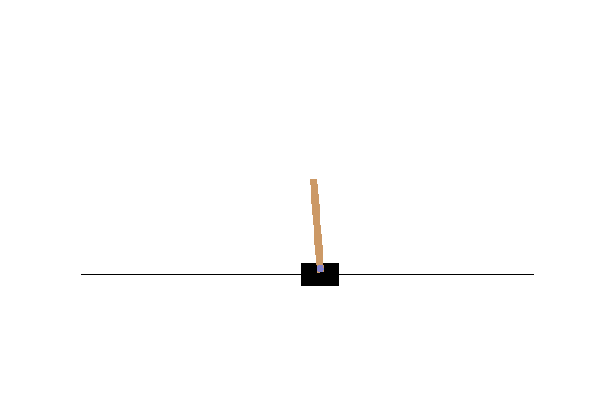
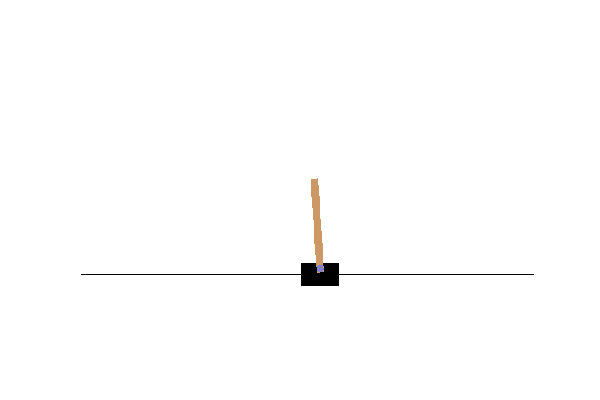
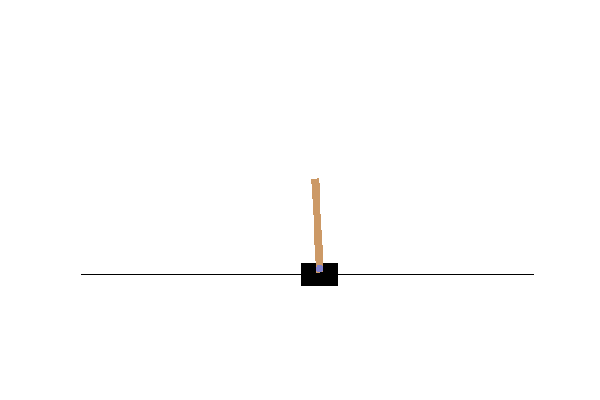
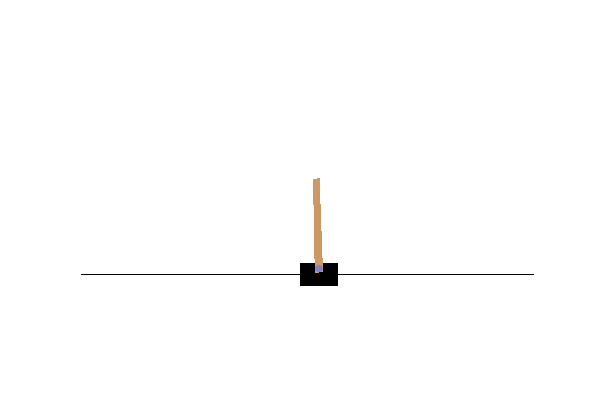
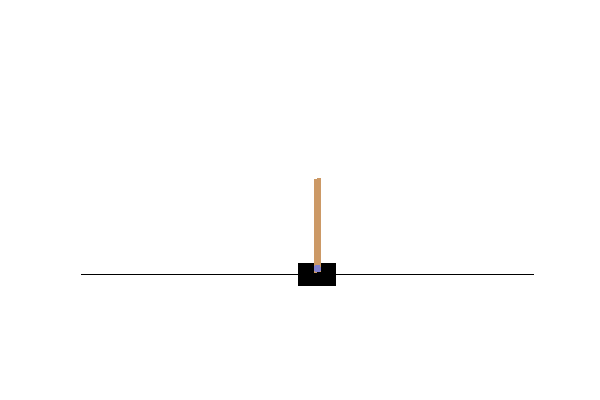
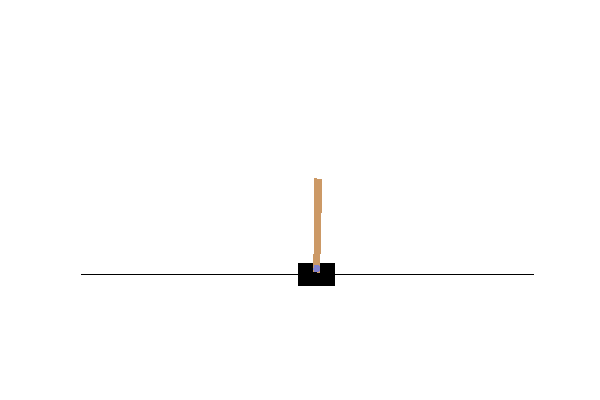
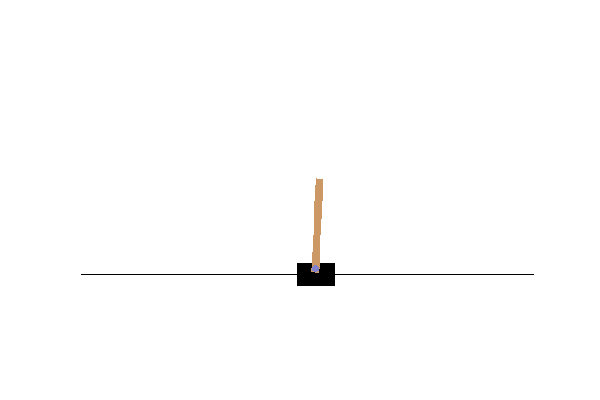
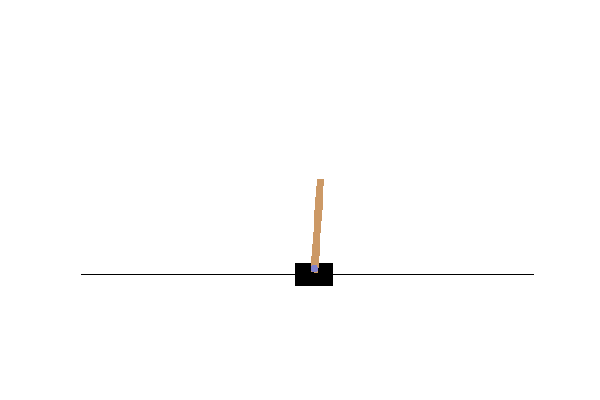
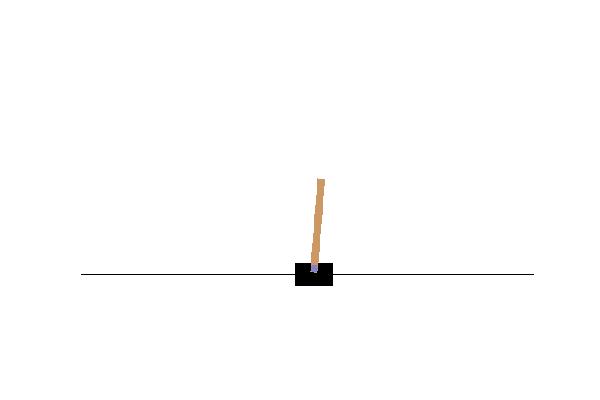
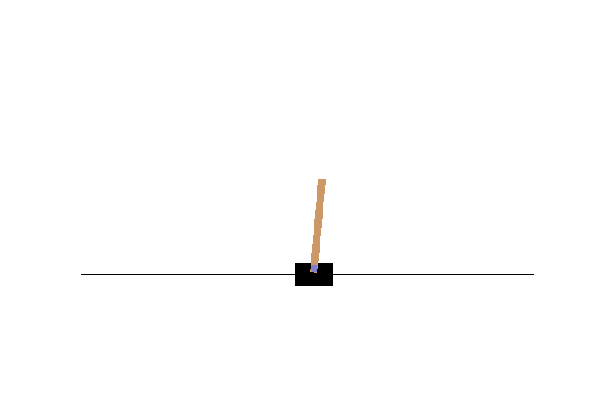
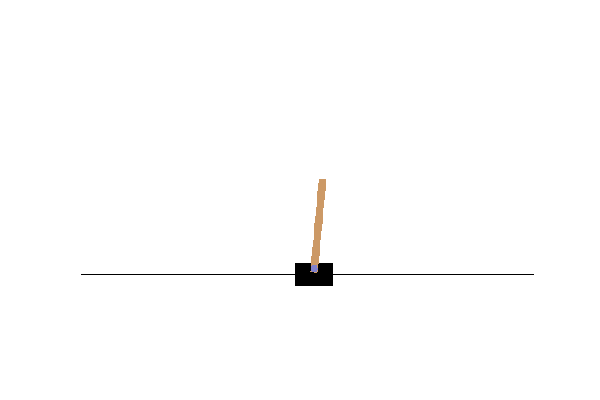
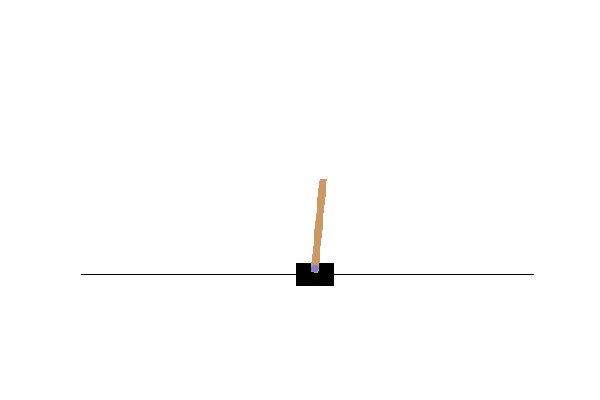
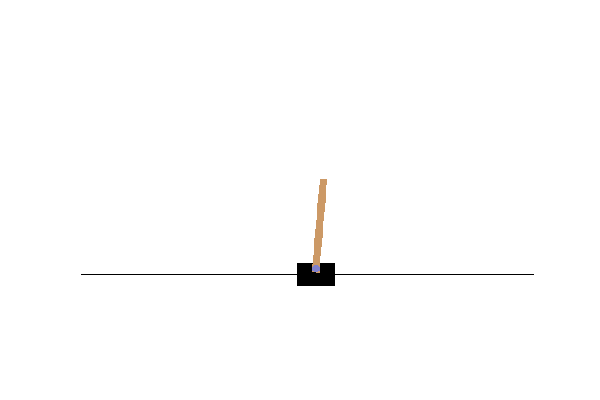
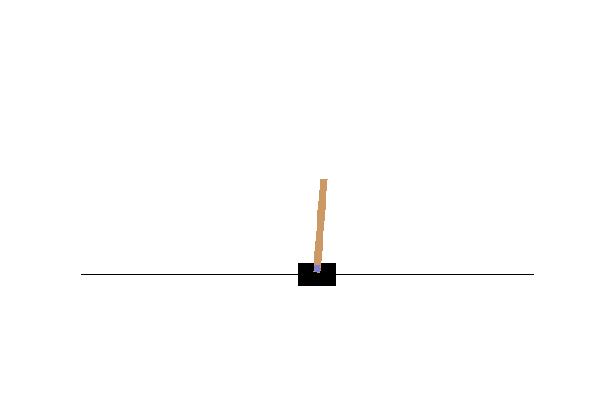
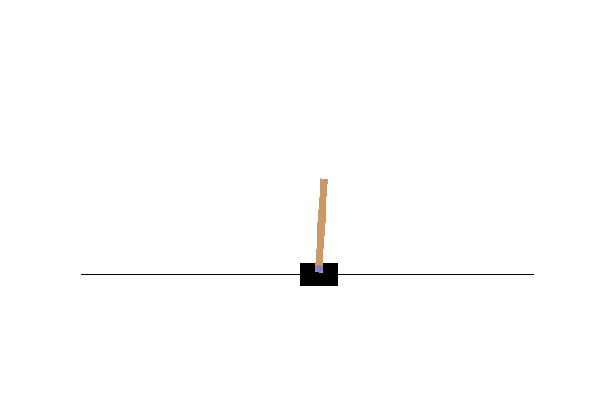
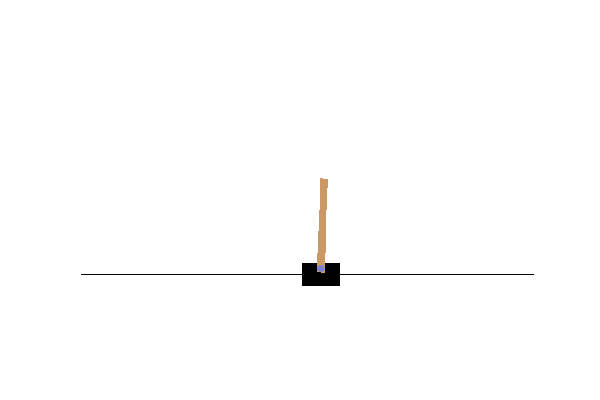
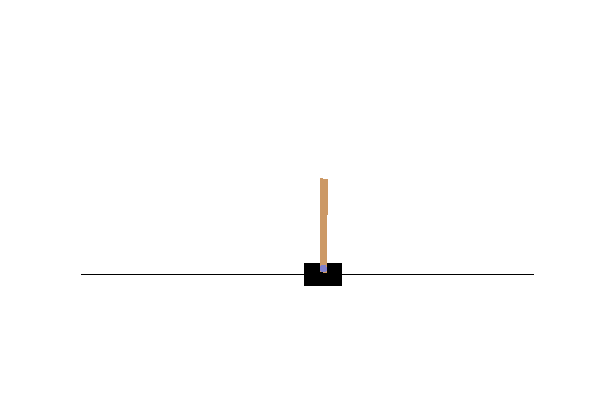
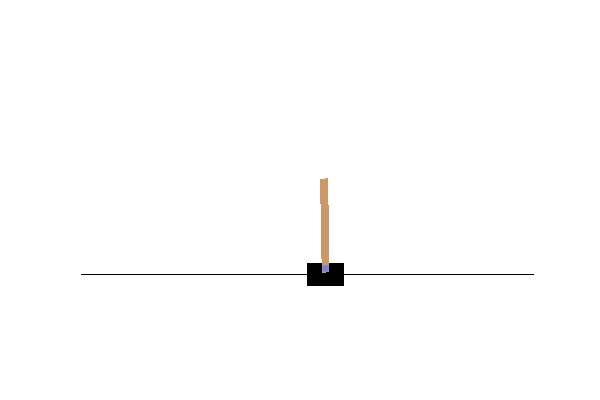
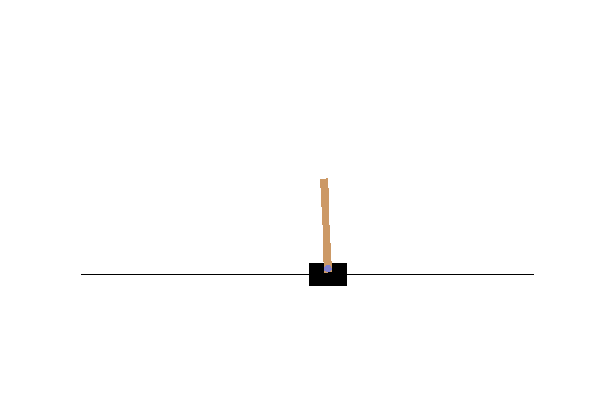
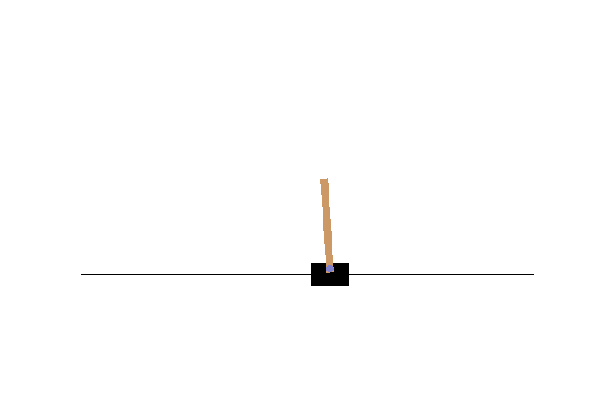
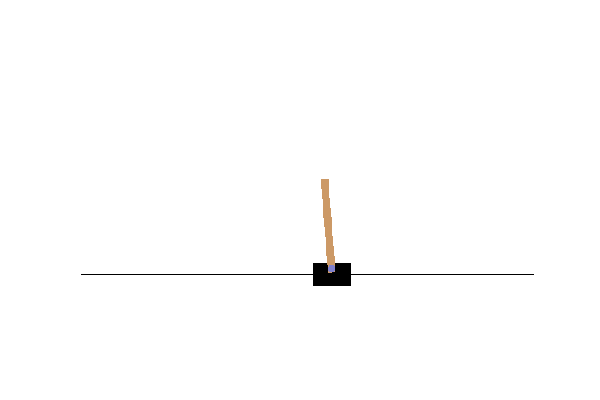
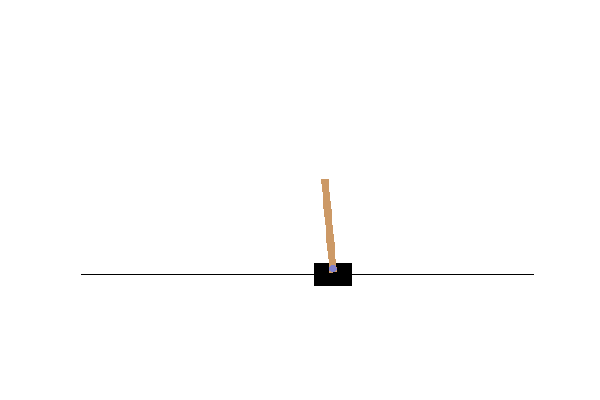
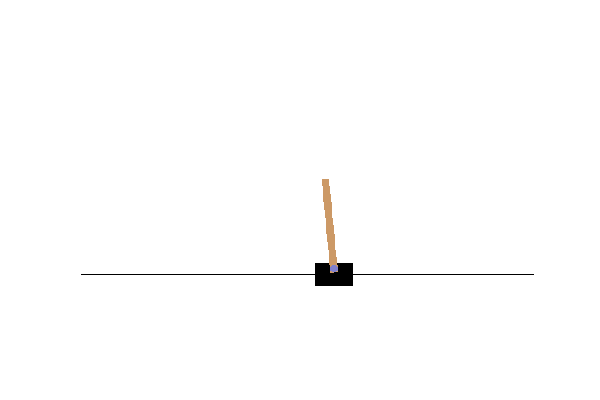
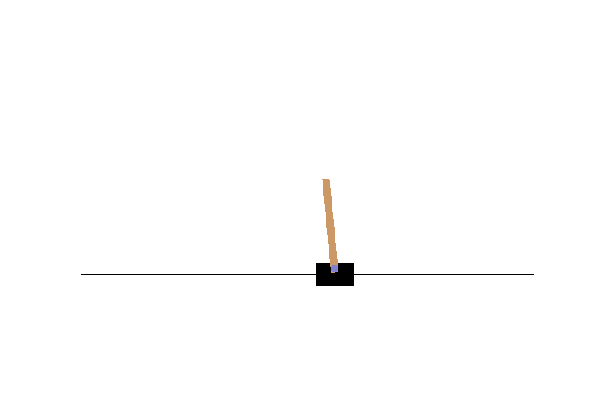
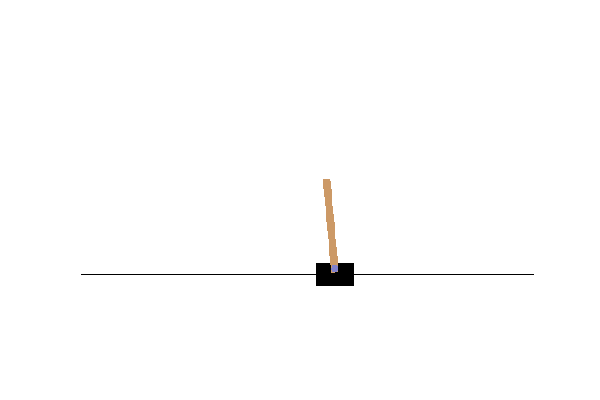
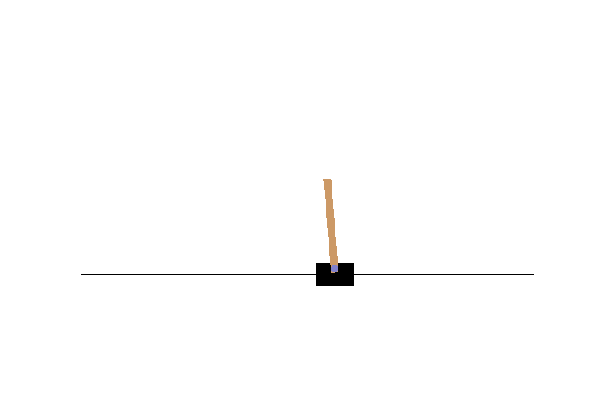
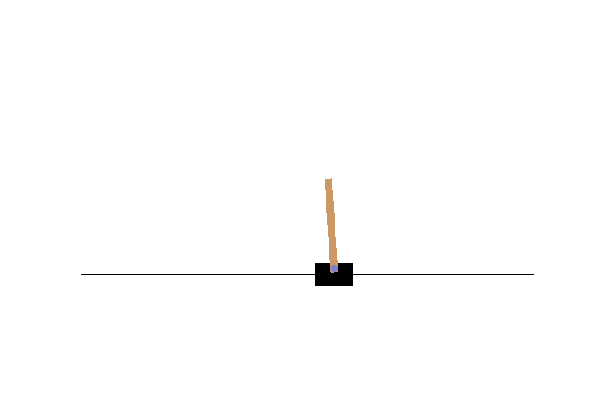
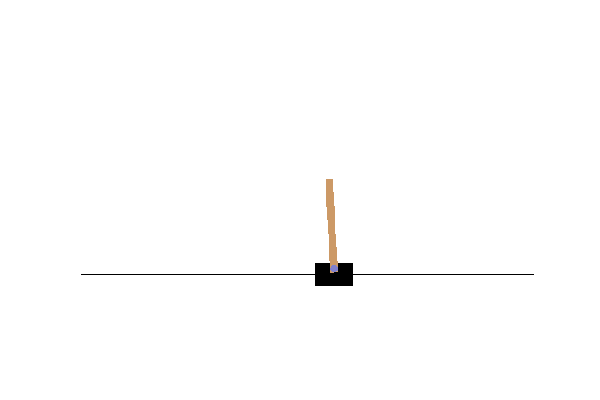
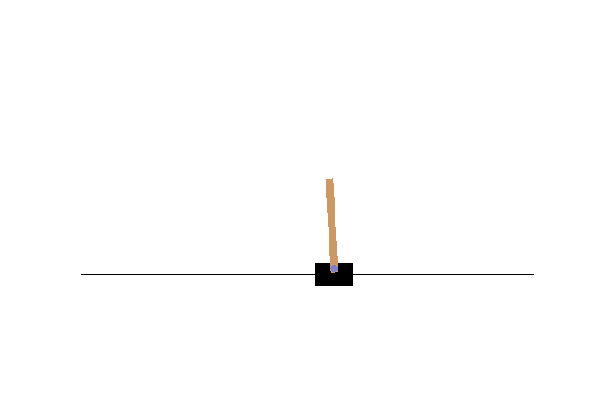
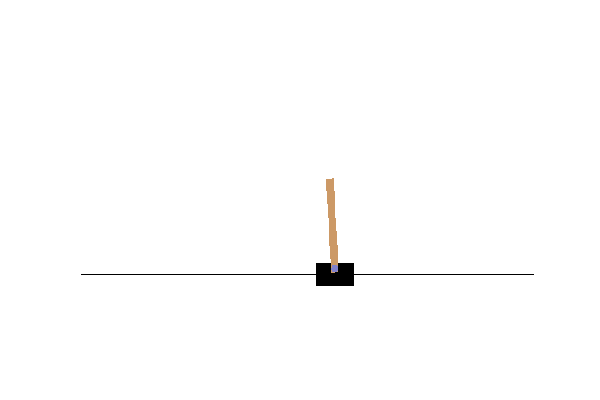
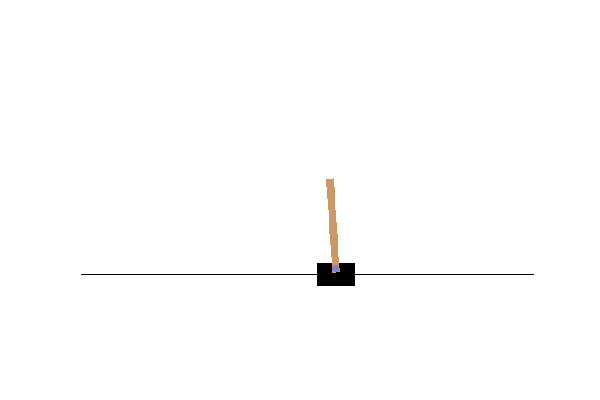
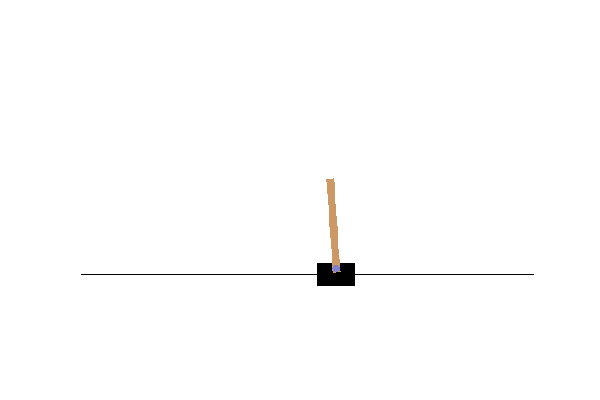
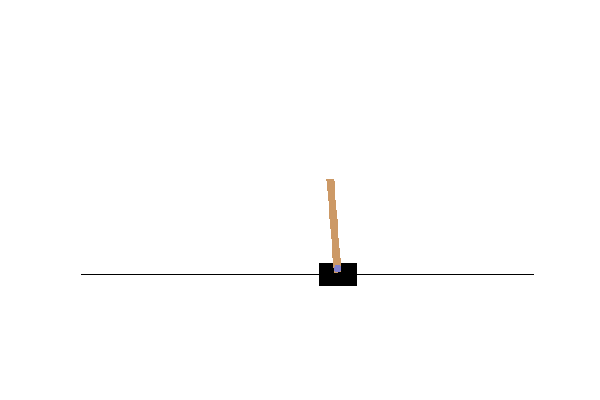
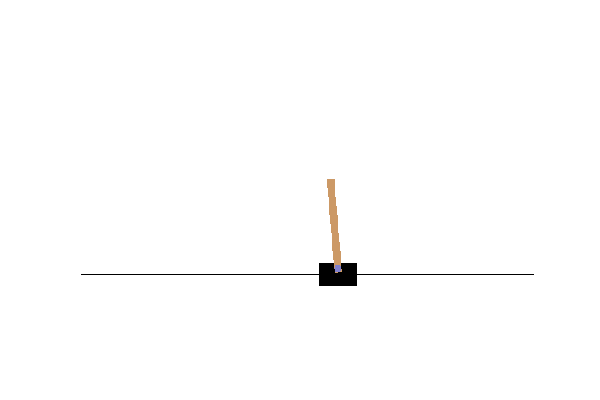
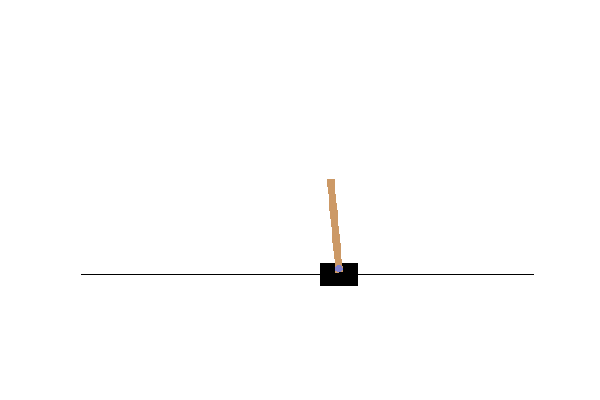
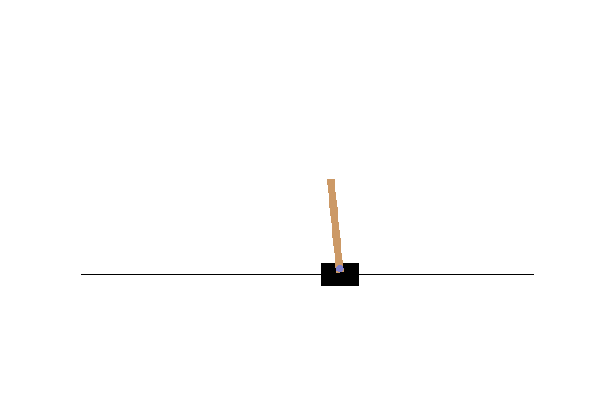
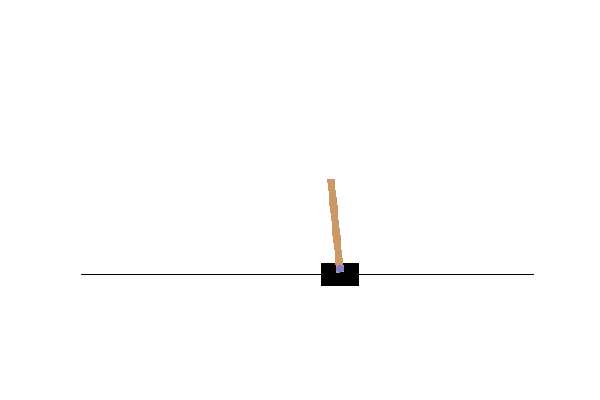
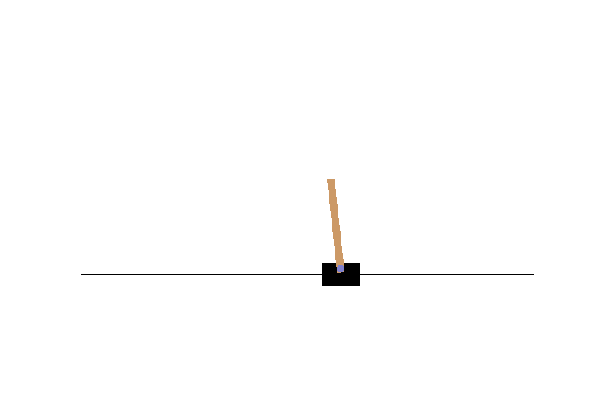
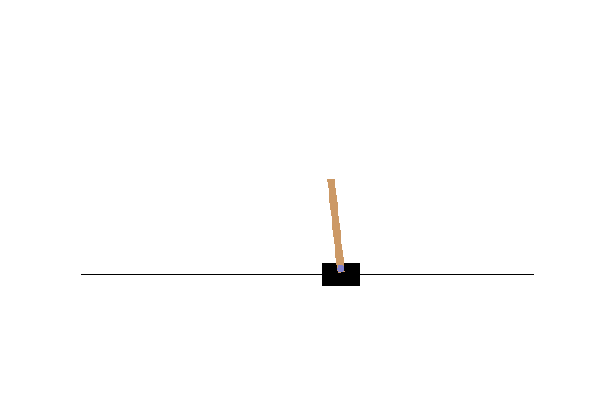
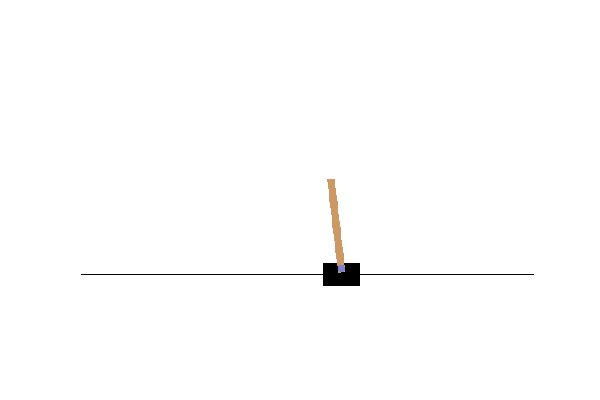
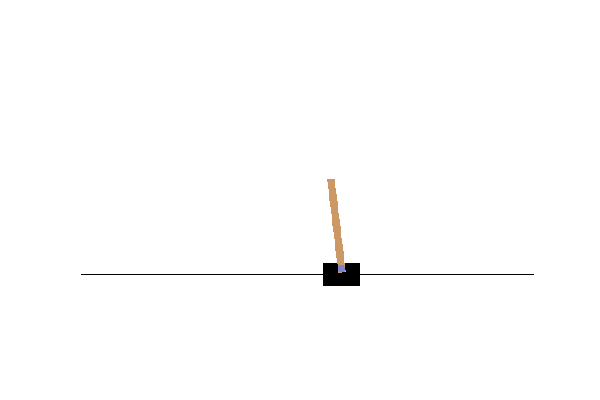
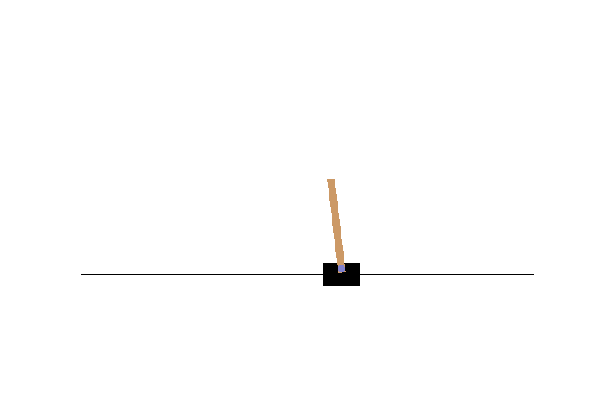
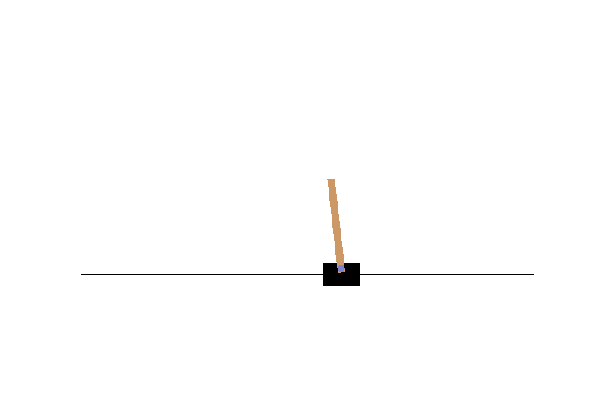
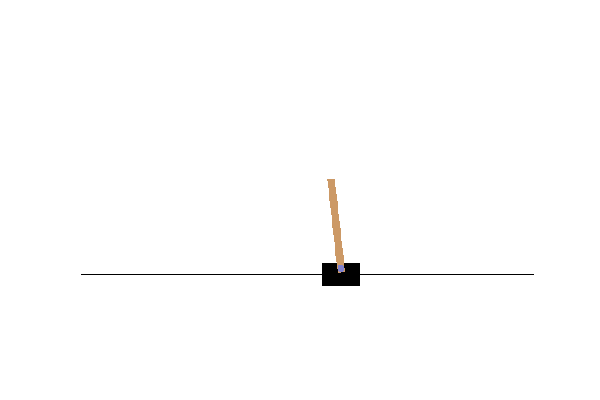
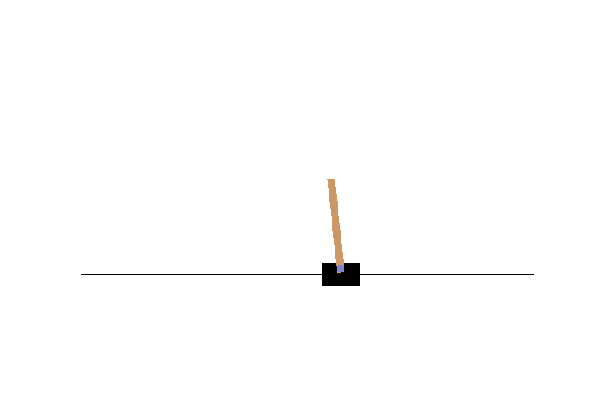
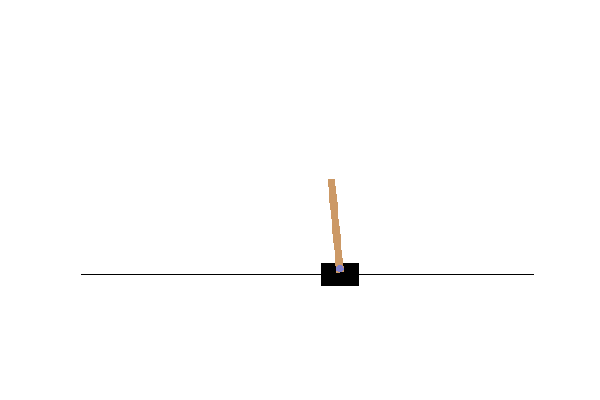
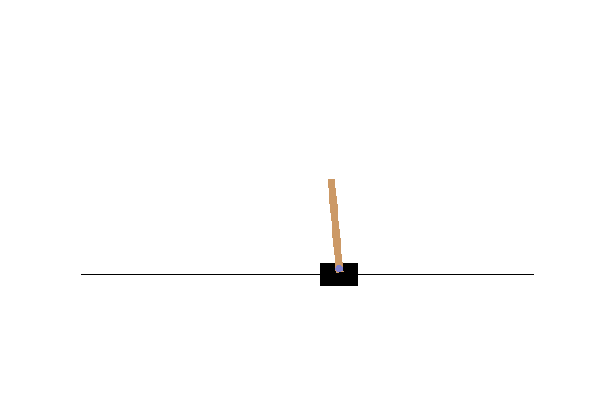
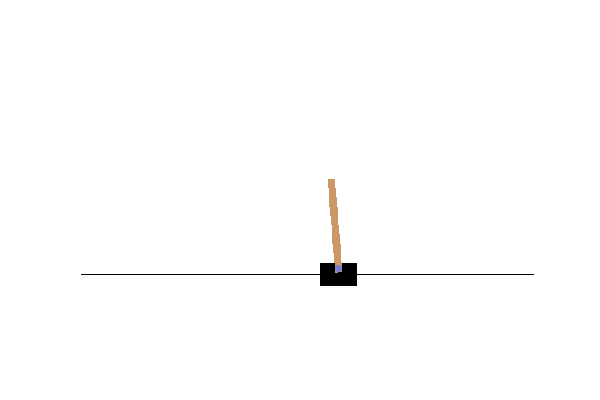
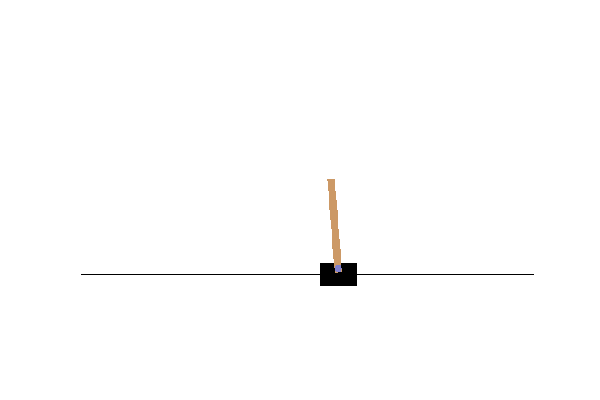
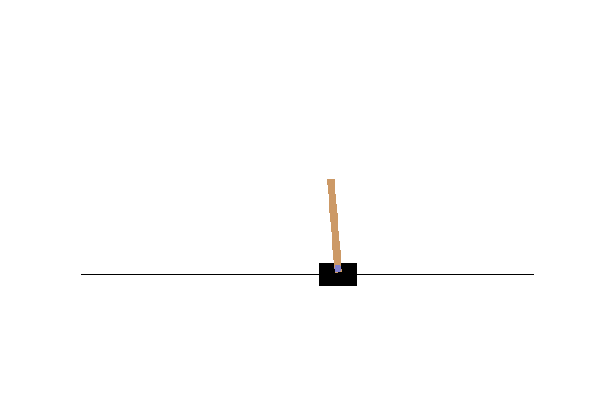
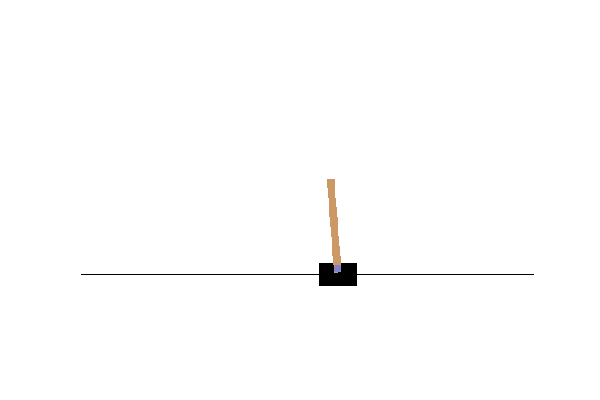
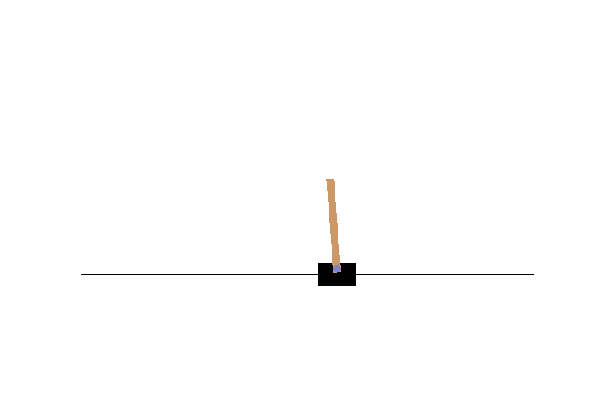
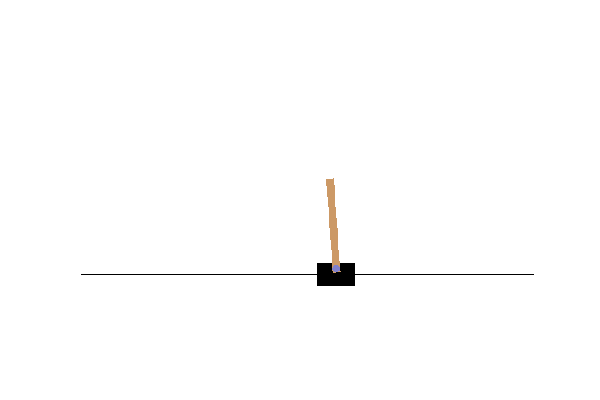
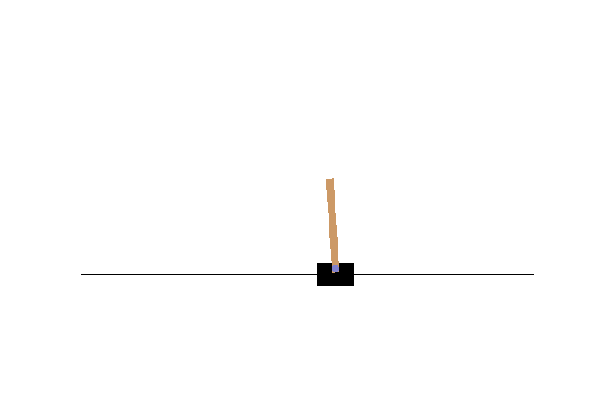
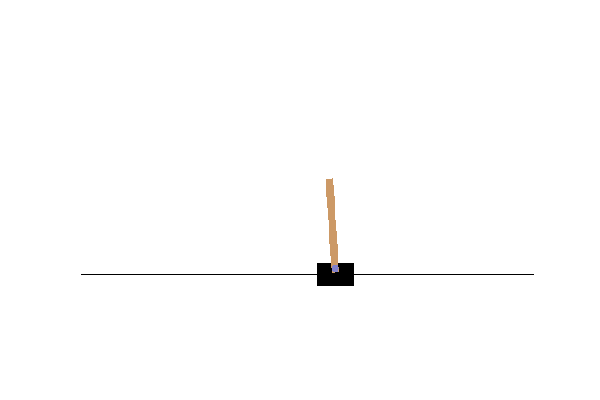
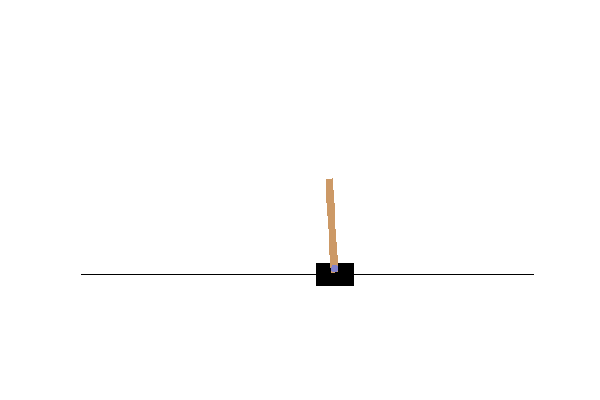
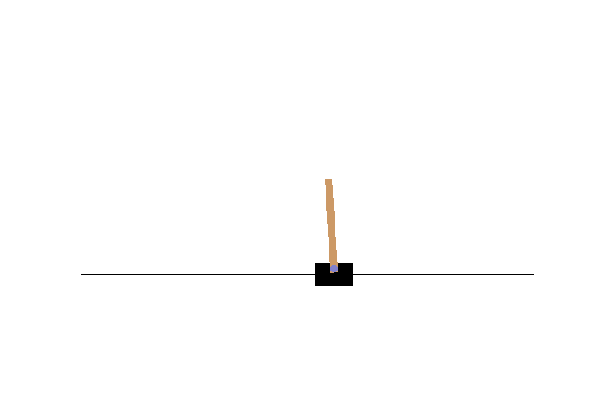
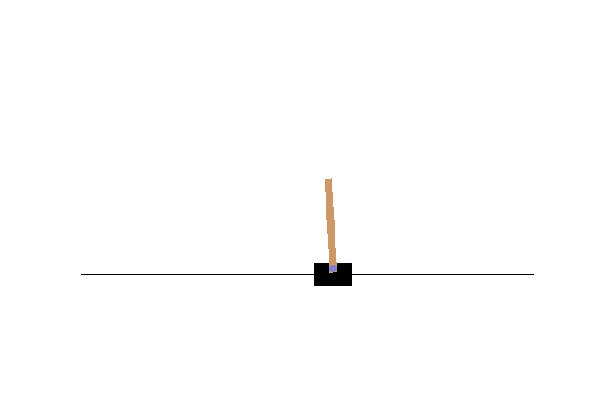
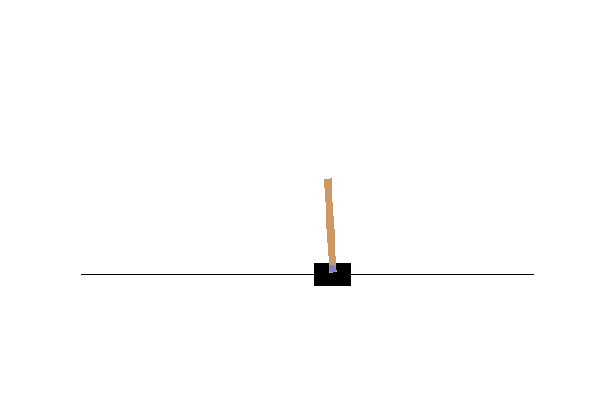
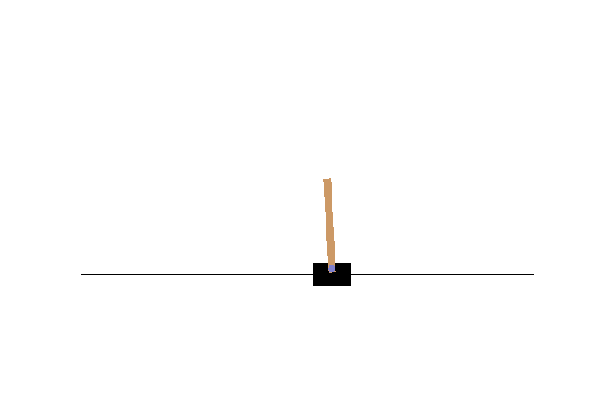
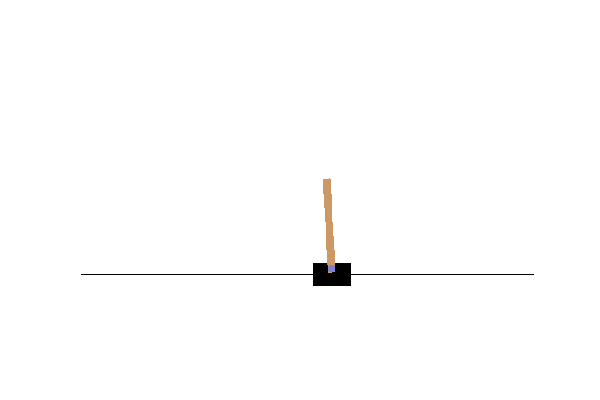
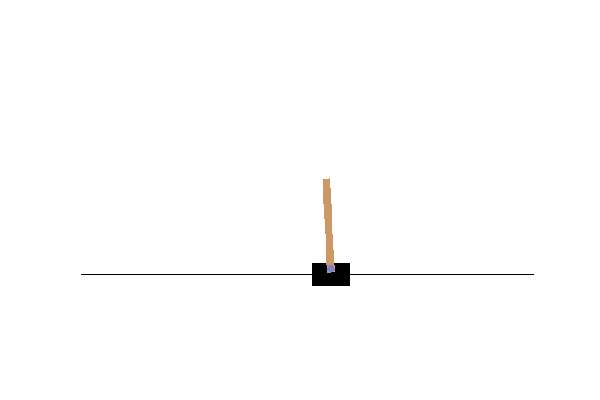
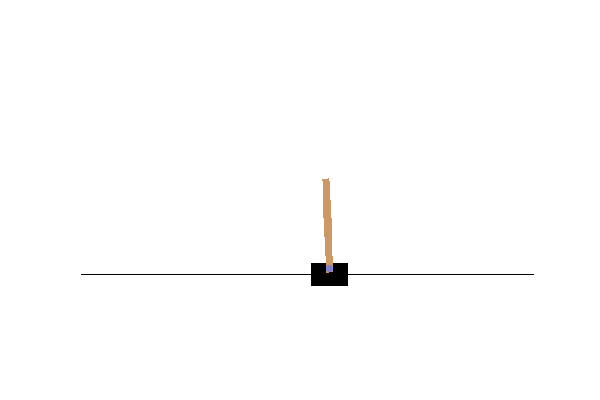
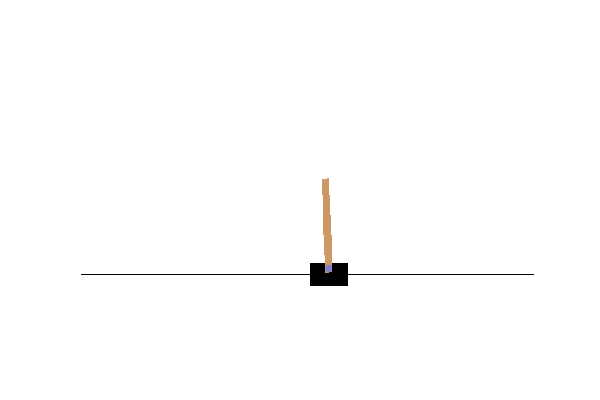
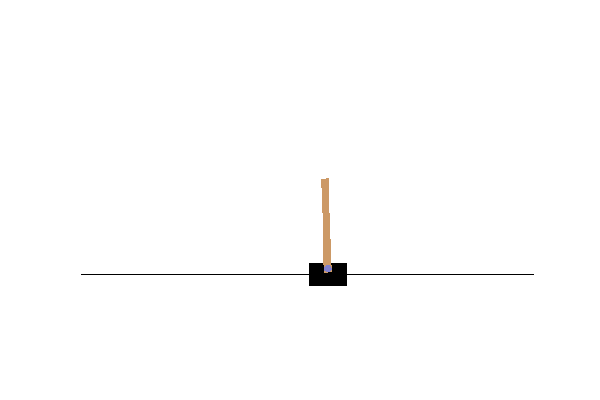
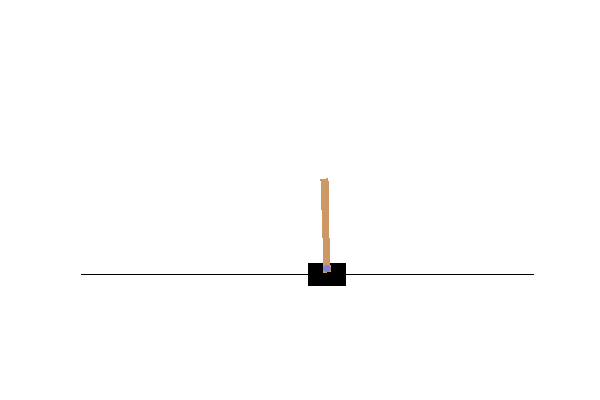
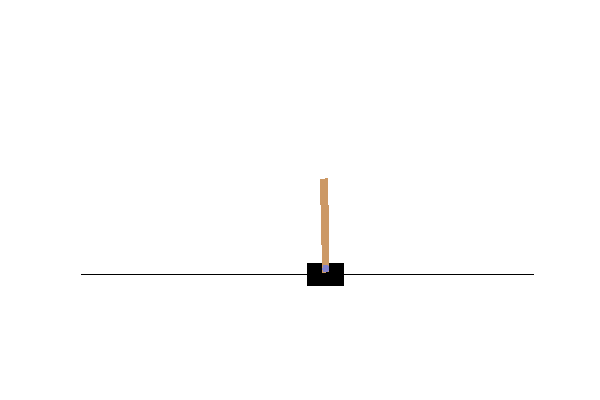
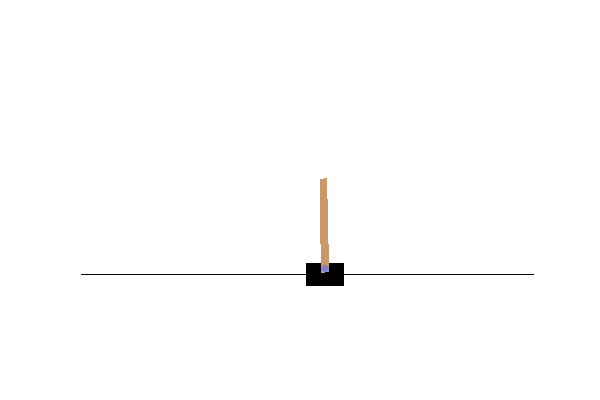
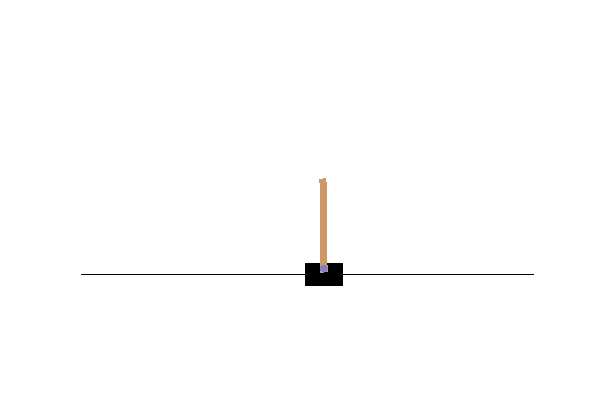
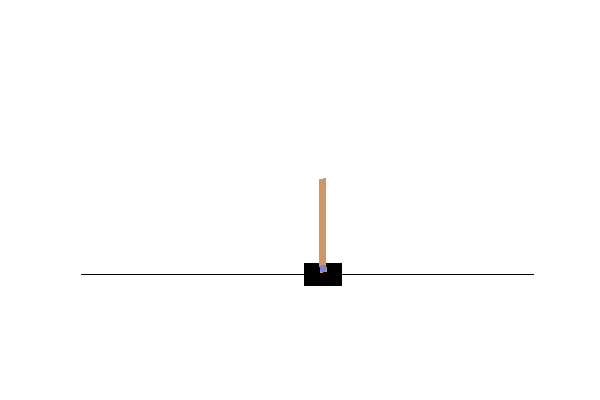
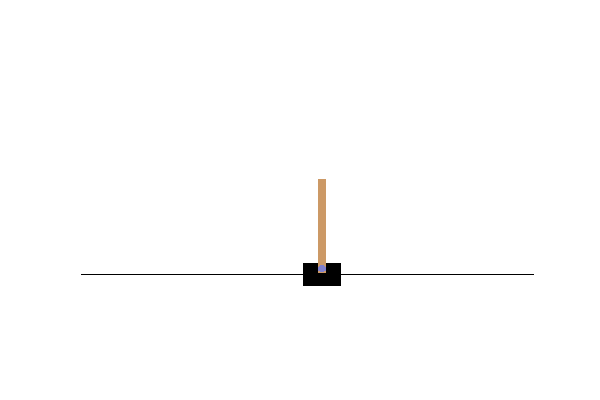
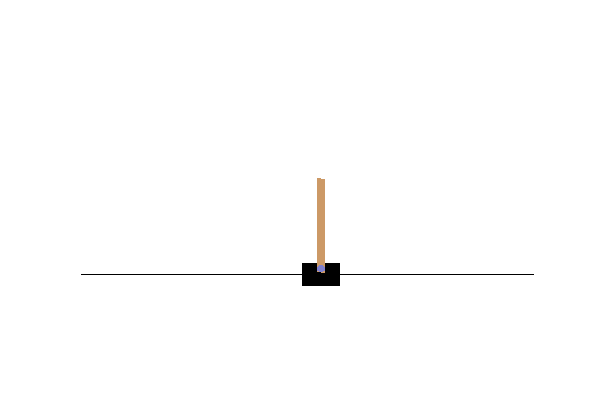
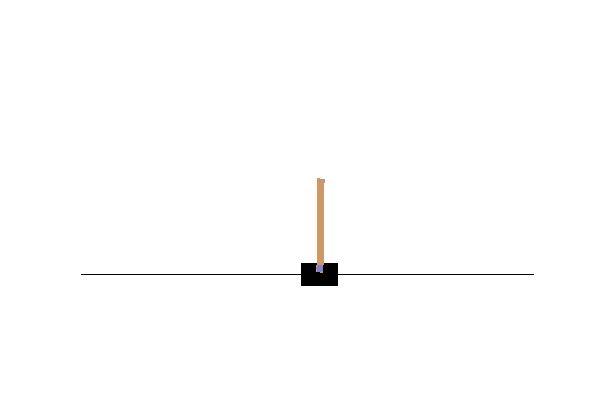
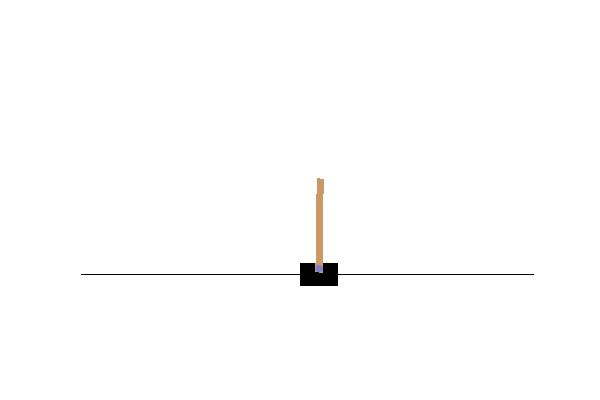
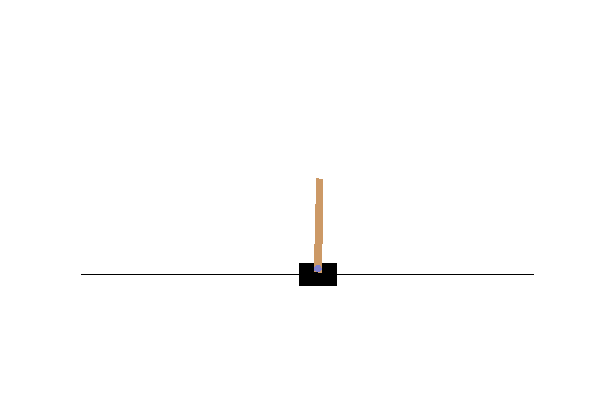
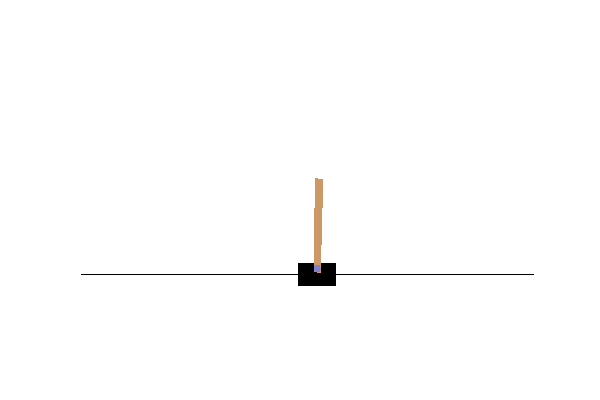
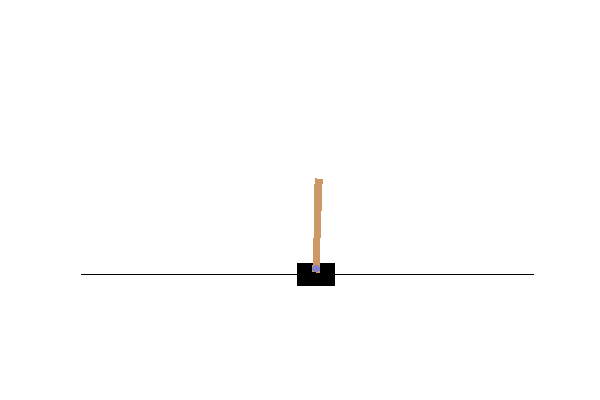
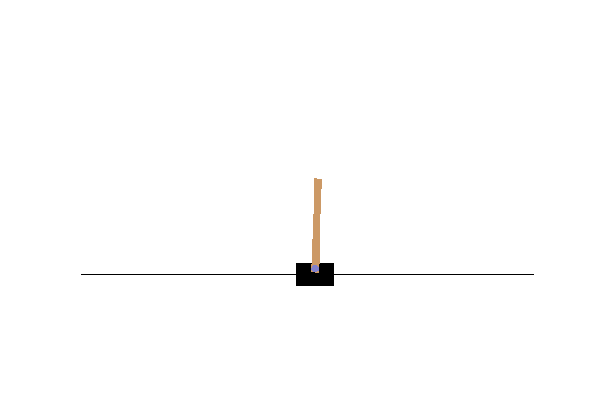
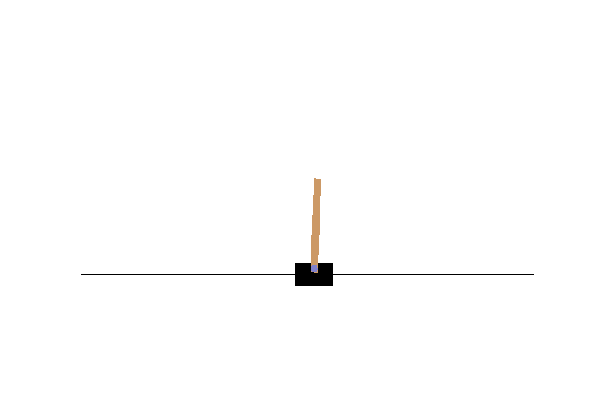
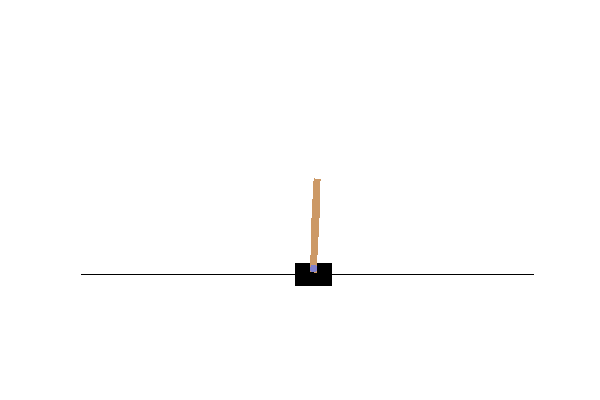
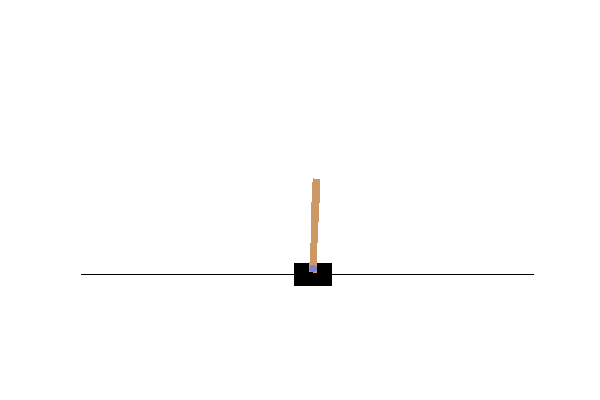
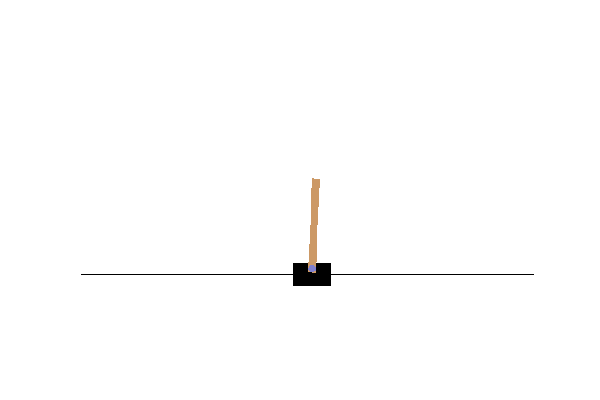
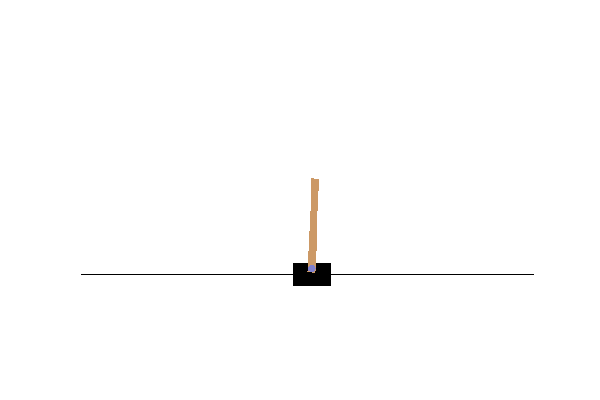
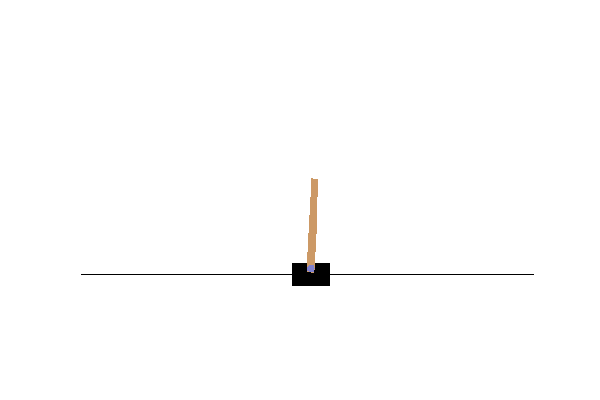
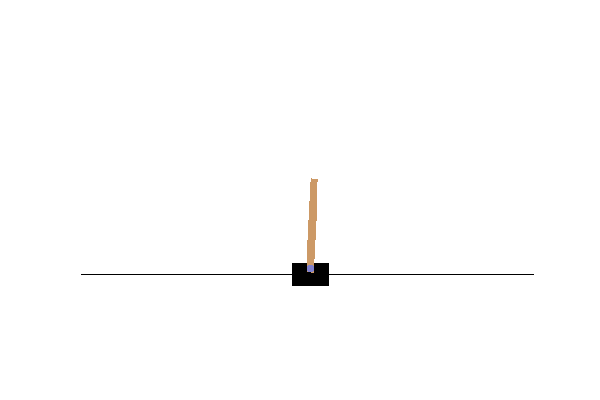
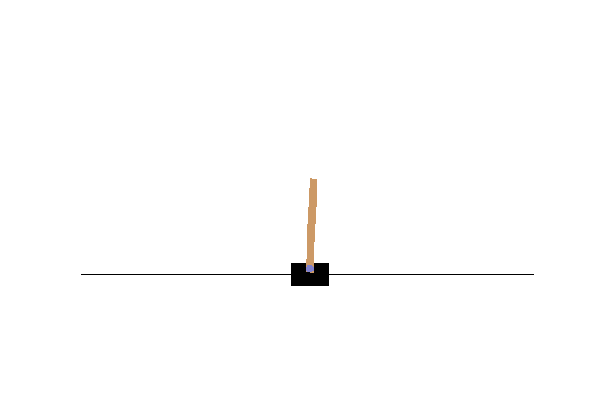
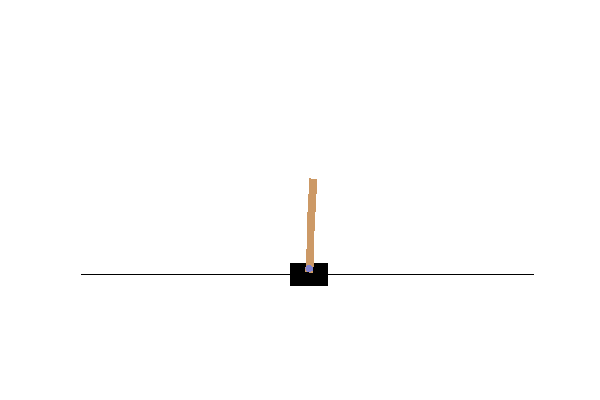
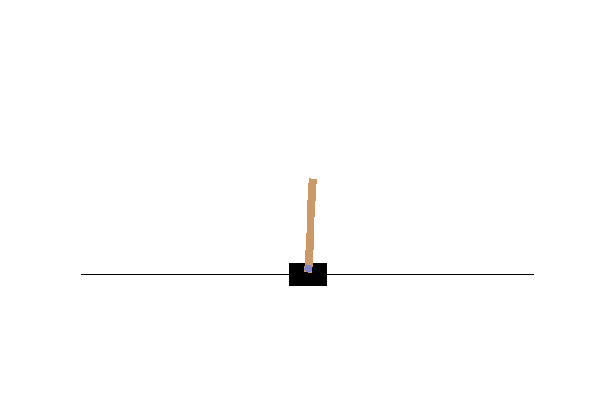
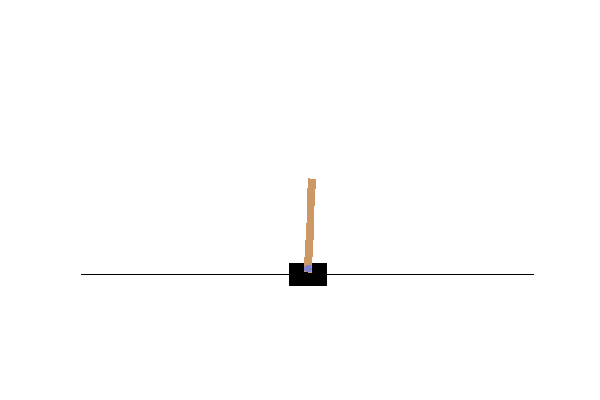
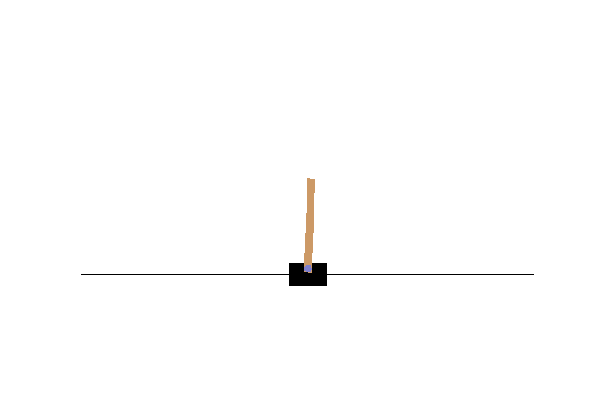
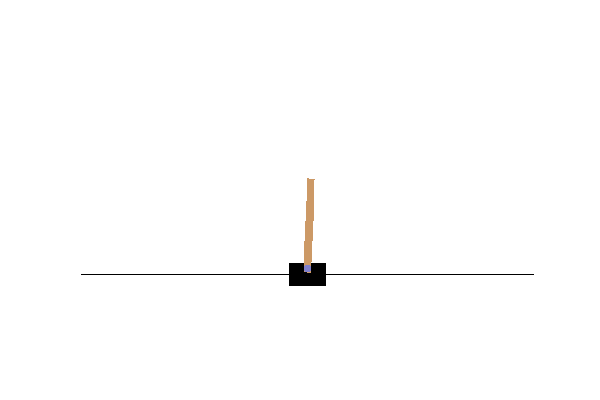
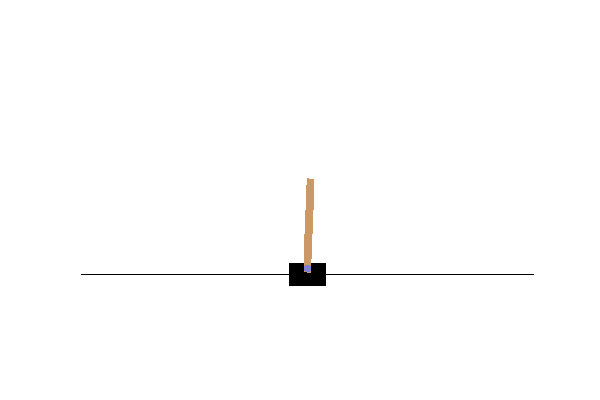
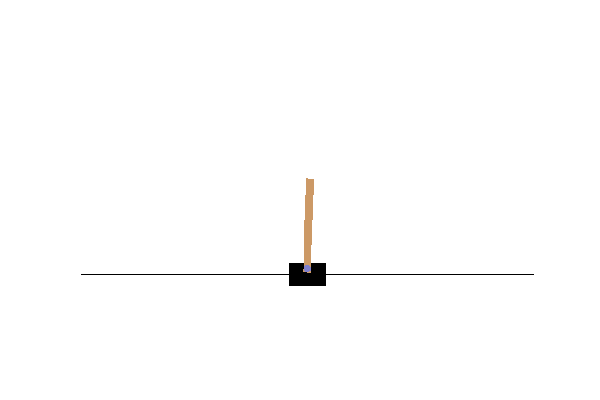
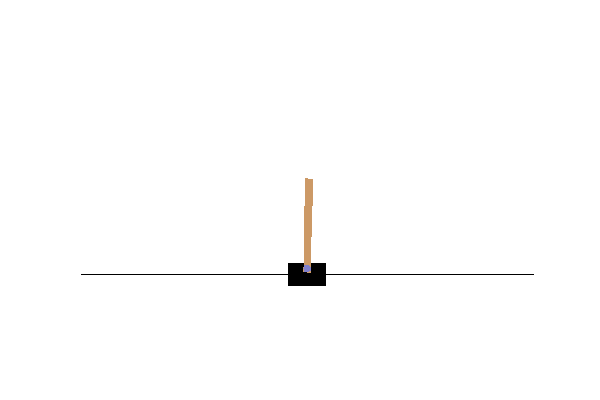
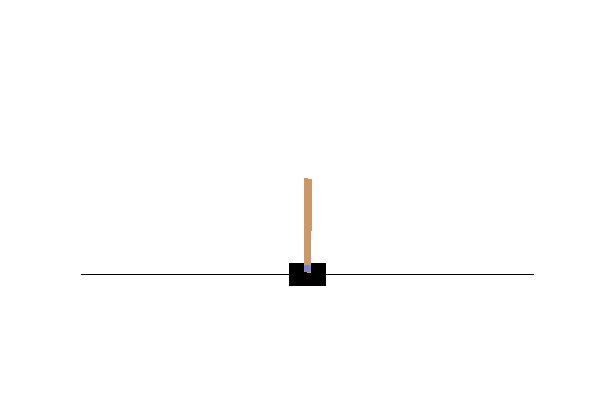
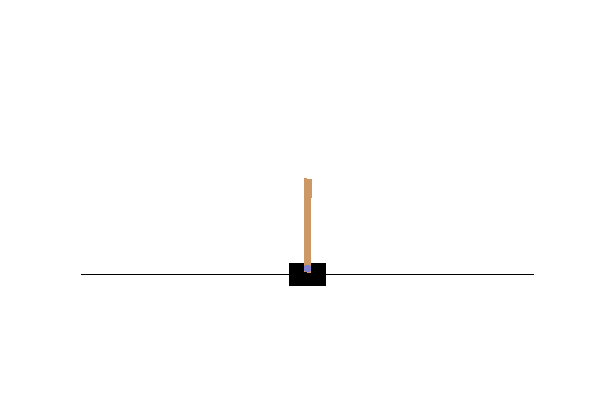
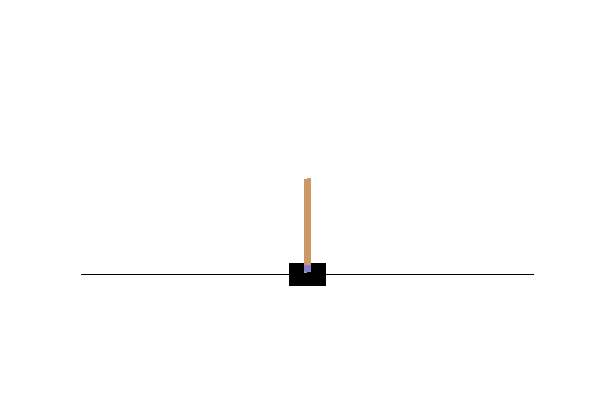
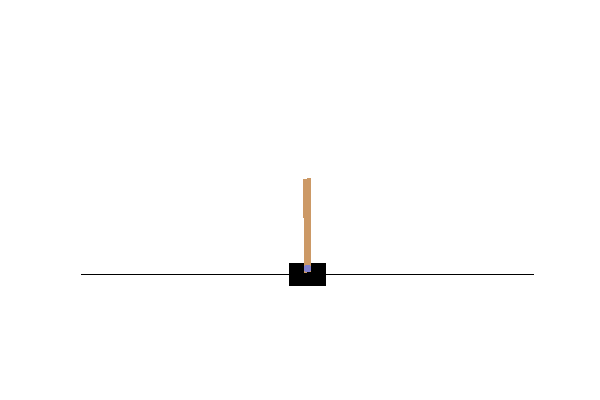
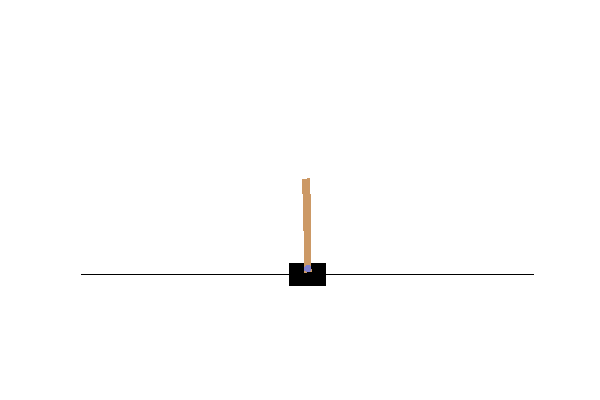
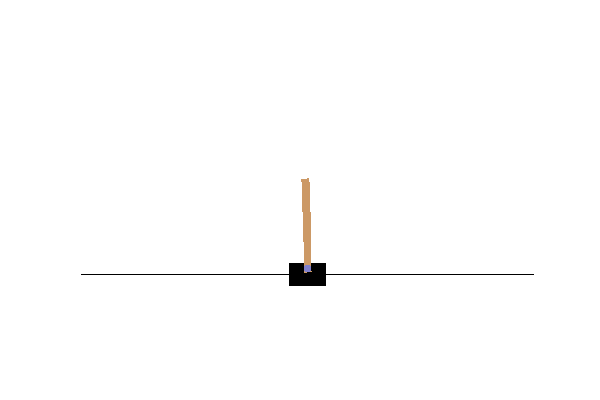
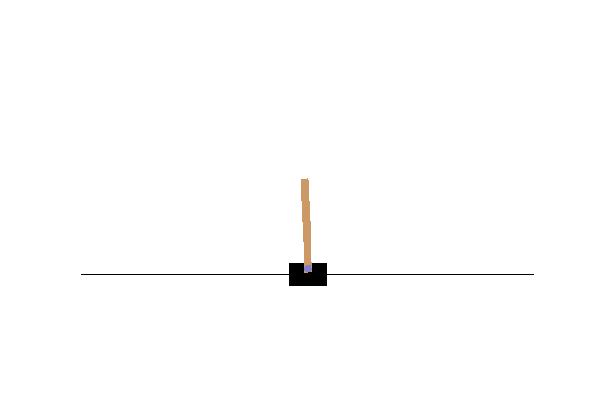
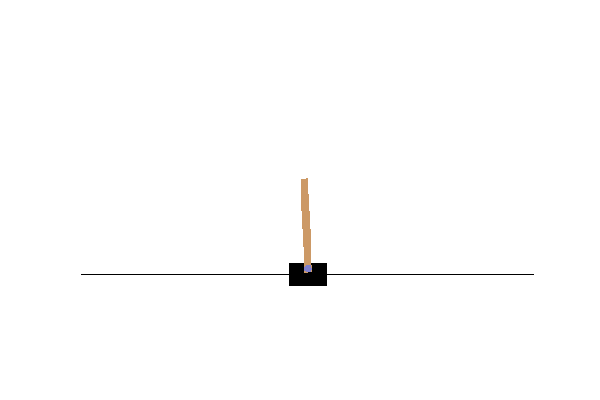
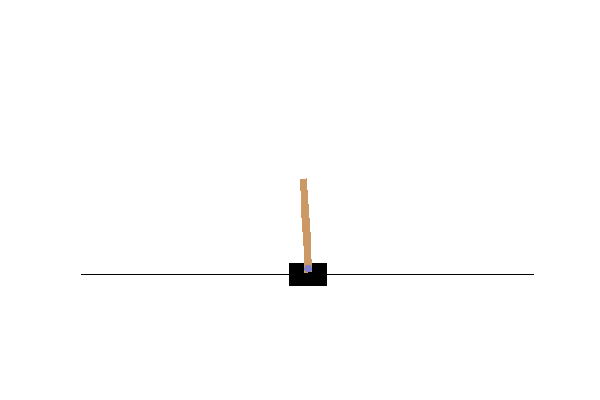
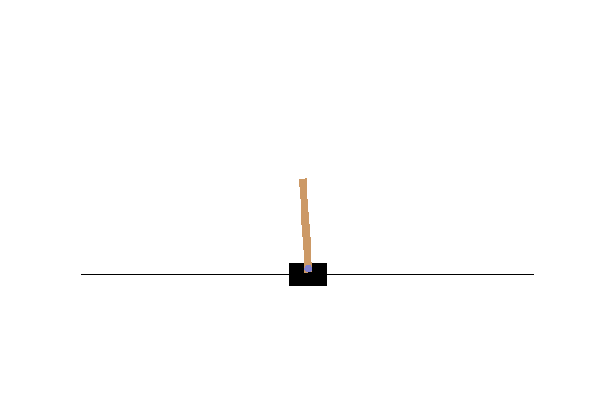
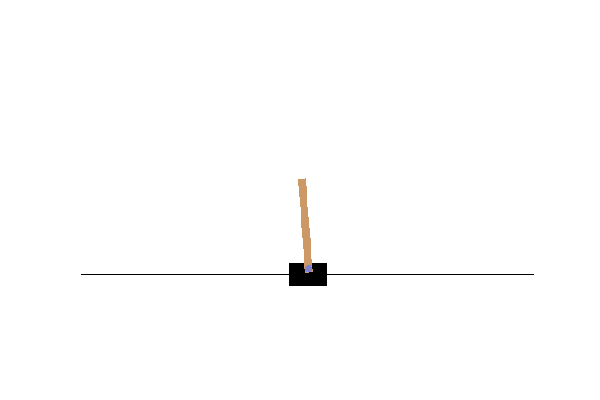
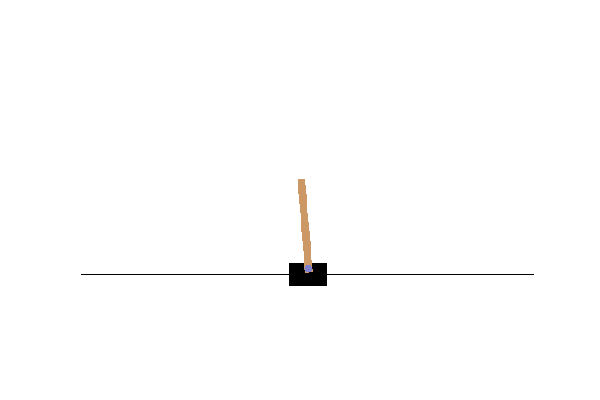
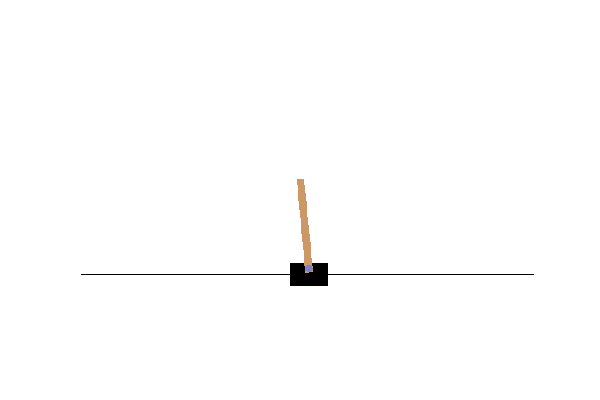
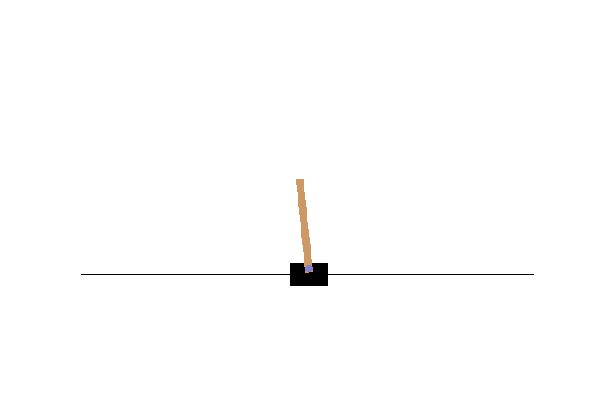
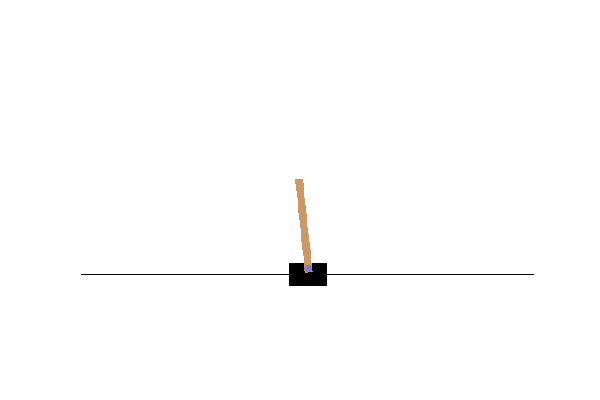
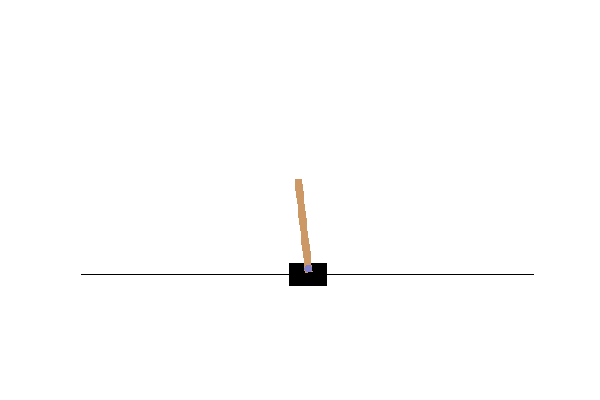
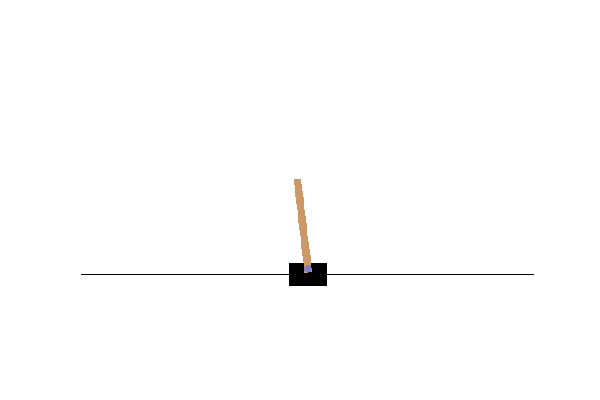
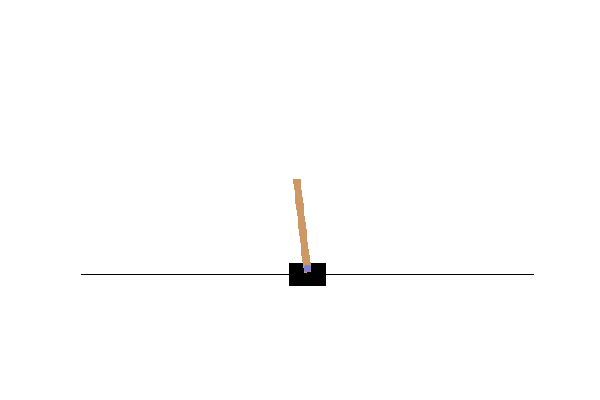
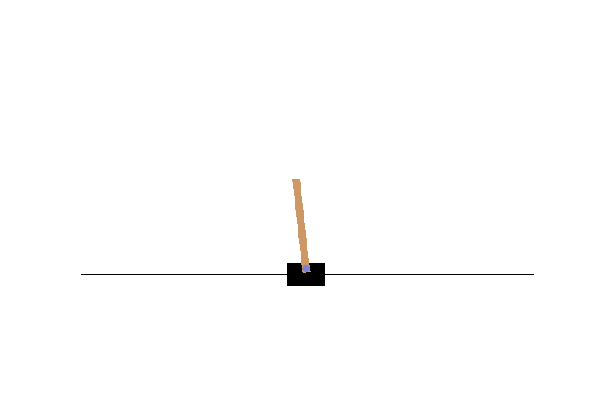
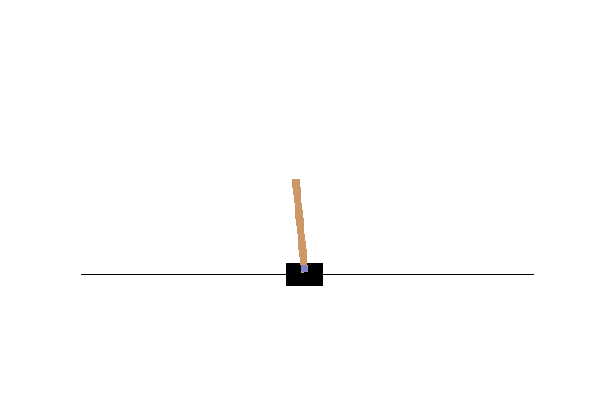
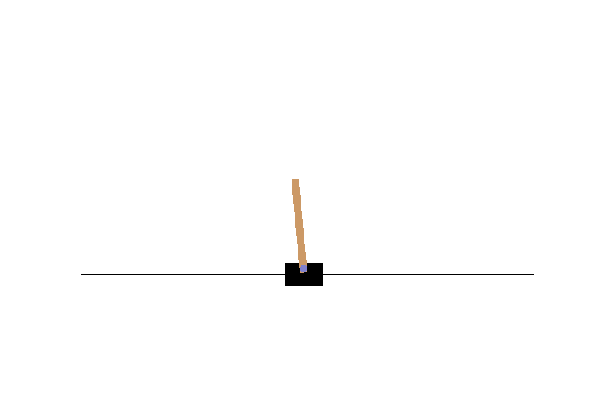
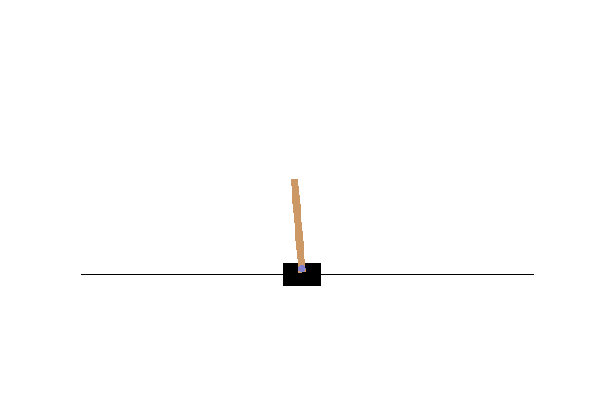
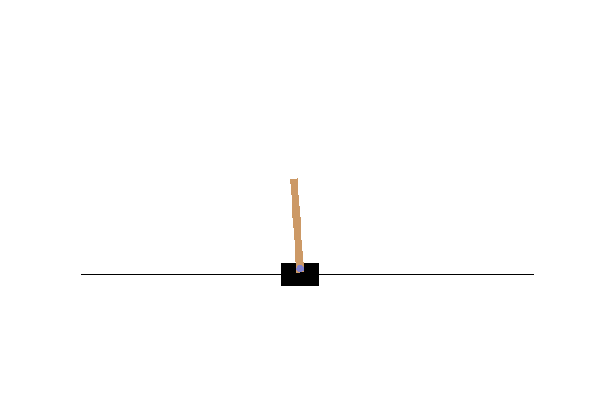
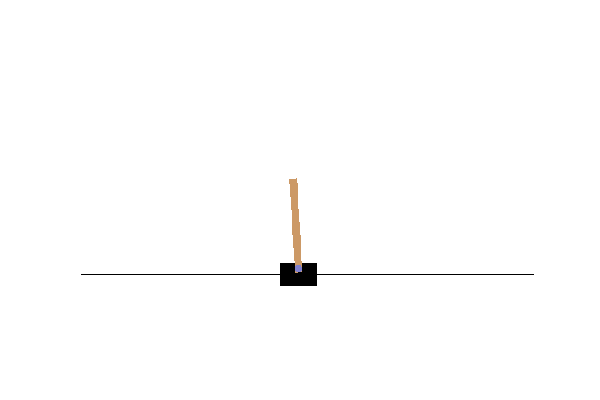
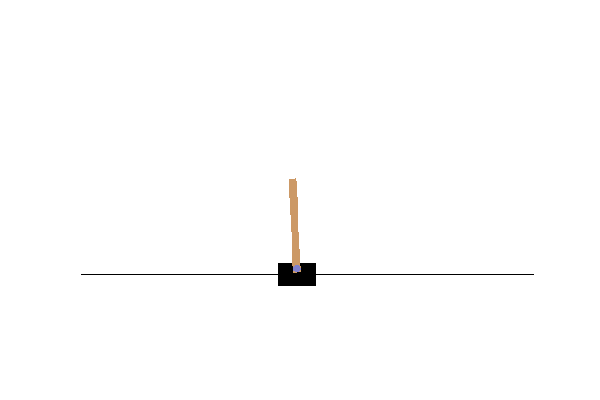
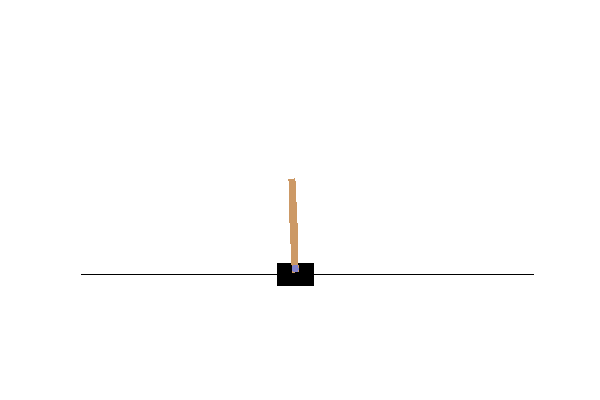
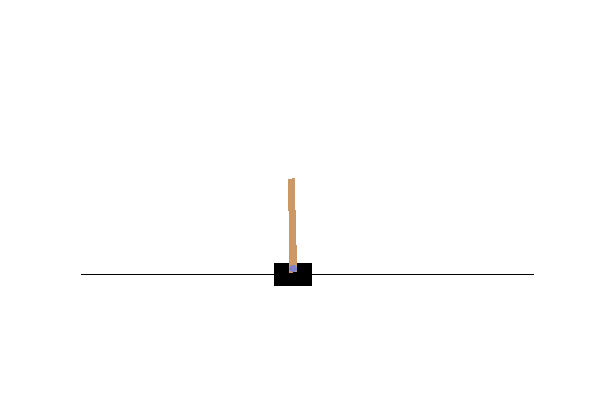
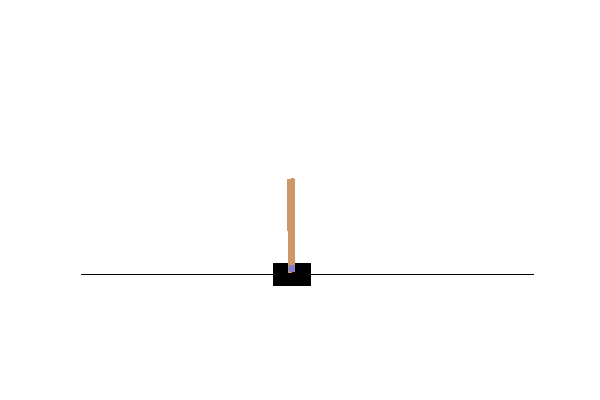
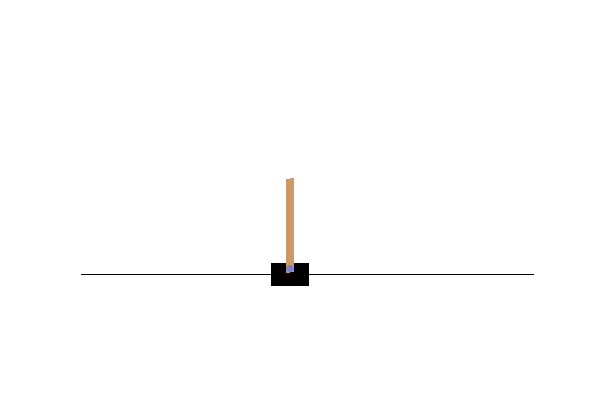
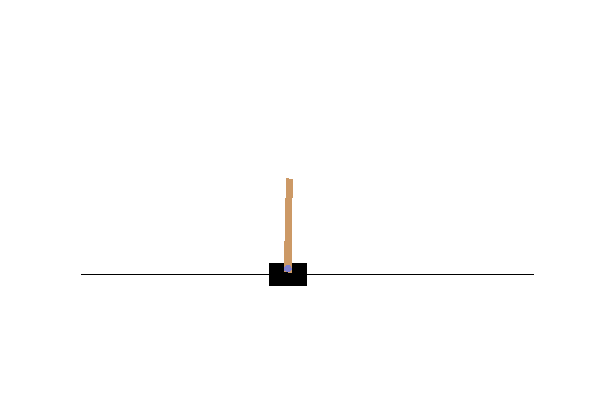
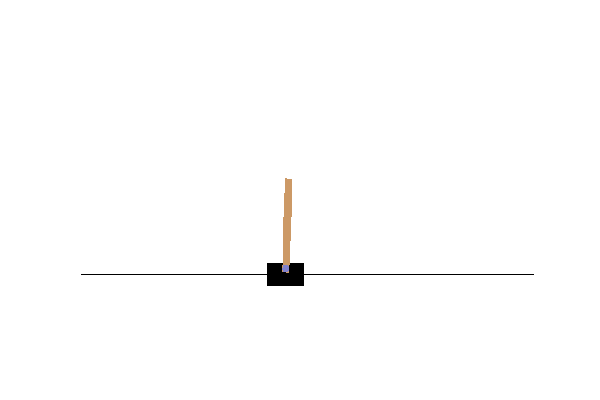
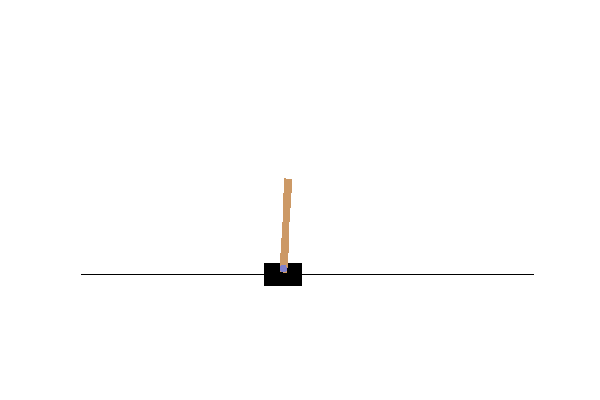
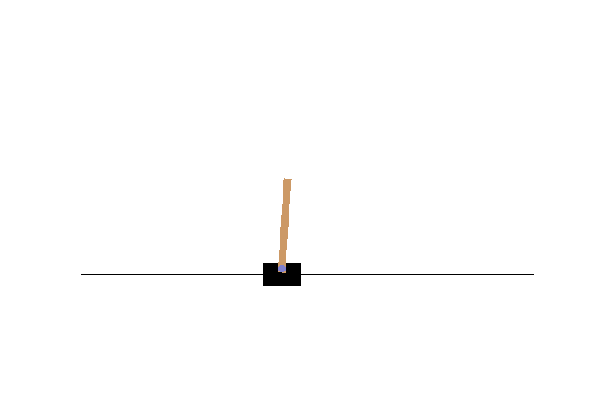
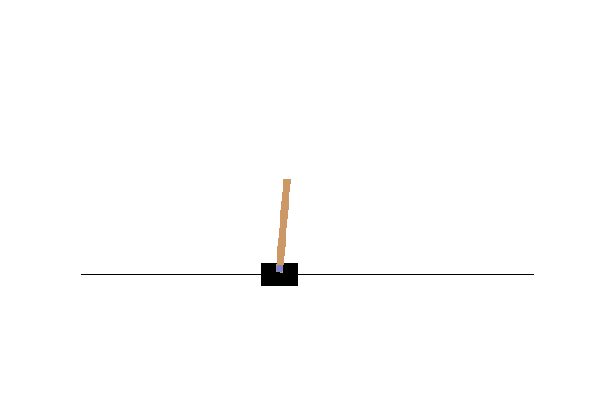
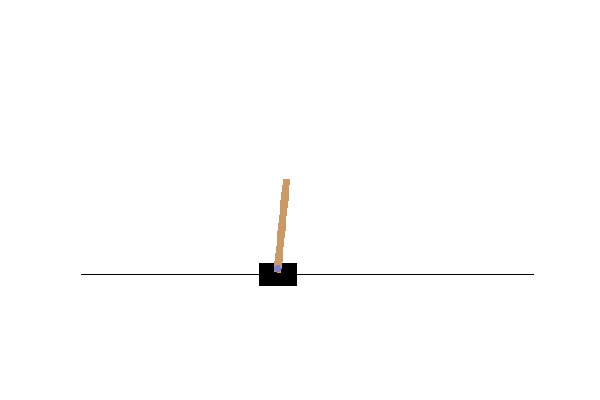
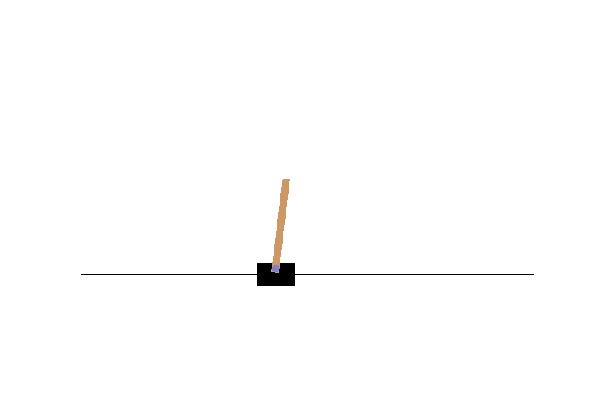

In [15]:
def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))

### Play till we are dead
observation = env.reset()
term = False
predicted_q = []
frames = []
while not term:
    rgb_observation = env.render(mode = 'rgb_array')
    frames.append(rgb_observation)
    pred_q = sess.run(predictedreward, feed_dict={networkstate:[observation]})
    predicted_q.append(pred_q)
    action = np.argmax(pred_q)
    observation, _, term, _ = env.step(action)
    
### Plot the replay!
display_frames_as_gif(frames,filename_gif='dqn_run.gif')

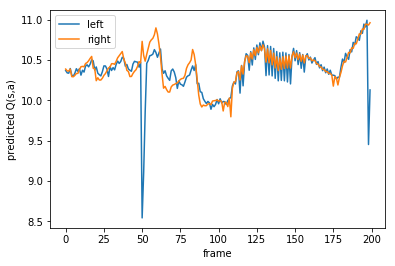

In [25]:
plt.plot([var[0] for var in predicted_q])
plt.legend(['left', 'right'])
plt.xlabel("frame")
plt.ylabel('predicted Q(s,a)')

## Handling difficult situations - team up with your robot
You can see in the graph above that our q-function, without the final mistake it made, has a good idea how well it is doing. At moments the pole is going sideways the maximum expected reward lowers. This is a good moment to team up with your robot and guide him when he is in trouble. 

Collaborating is easy: if your robot does not know what to do, we can ask the user to provide input. The initial state the robot is in gives us a lot of information: $Q(S,a)$ tells us how much reward the robot expects for the next frames of its run. If during execution of the robots strategy the maximum expected $Q$ drops a bit below this number we can interpret this as the robot being in a dire situation. We then ask for the user to say if the cart should move left or right. 

Note that in the graph above the agent died, even though it expected a lot of reward. This method is not foolproof, but does help the agent to survive longer. 

In [ ]:
%matplotlib inline
plt.ion()
observation = env.reset()

### We predict the reward for the initial state, if we are slightly below this ideal reward, let the human take over. 
TRESHOLD = max(max(sess.run(predictedreward, feed_dict={networkstate:[observation]})))-0.2
TIME_DELAY = 0.5 # Seconds between frames 
terminated = False
while not terminated:
    ### Show the current status
    now = env.render(mode = 'rgb_array')
    plt.imshow(now)
    plt.show()

    ### See if our agent thinks it is safe to move on its own
    pred_reward = sess.run(predictedreward, feed_dict={networkstate:[observation]})
    maxexpected = max(max(pred_reward))
    if maxexpected > TRESHOLD: 
        action = np.argmax(pred_reward)
        print("Max expected: " + str(maxexpected))
        time.sleep(TIME_DELAY)
    else:
        ### Not safe: let the user select an action!
        action = -1
        while action < 0:
            try:
                action = int(raw_input("Max expected: " + str(maxexpected) + " left (0) or right(1): "))
                print("Performing: " + str(action))
            except:
                pass
    
    ### Perform the action
    observation, _, terminated, _ = env.step(action)

print("Unfortunately, the agent died...")

### Exercises
Now that you and your neural network can balance a stick there are many things you can do to improve. As everyones skills are different I wrote down some ideas you can try:
#### Machine learning starter: 
- Improve the neural network. You can toy around with layers (size, type), tune the hyperparameters, or many more. 
- Toy around with the value of gamma, visualise for several values what kind of behaviour the agent will exercise. Is the agent more careful with a higher gamma value?
#### Tensorflow starter: 
- If you don't have a lot of experience you can either try to improve the neural network, or you can experiment with the Tensorboard tool. Try to add plots of the average reward during training. If you implemented epsilon-greedy exploration this number should go up during training. 
#### Reinforcement learning starter: 
- Because our agent only performs random actions our network dies pretty often during training. This means that it has a good idea what to do in its start configurations, but might have a problem when it survived for a longer time. Epsilon-greedy exploration prevents this. With this method you roll a die: with probability epsilon you take a random action, otherwise you take the action the agent thinks is best. You can either set epsilon to a specific value (0.25? 0.1?) or gradually take a lower value to encourage exploration. 
- Team up with your agent! We already help our agent when he thinks he is in a difficult situation, we could also let it ask for help during training. By letting the agent ask for help with probability epsilon you explore the state space in a way that makes more sense than random exploration, and this will give you a better agent. 
#### Reinforcement learning itermediate: 
- Right now we only visualise the loss, which is no indication for how good the network is. According to the paper [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) the average expected $Q$ should go up during learning (in combination with epsilon-greedy exploration). 
- Artur Juliani suggests that you can use a [target network](https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df). During training your network is very "unstable", it "swings" in all directions which can take a long time to converge. You can add a second neural network (exactly the same layout as the first one) that calculates the predicted reward. During training, every $X$ frames, you set the weights of your target network equal to the weights of your other network. 


### Conclusion
In part two we implemented a deep q-network in Tensorflow, and used it to control a cartpole. We saw that the network can "know" when it has problems, and then teamed up with our agent to help him out. Hopefully you enjoyed working with neural networks, the OpenAI gym, and working together with your agent. 

Initially I wanted to dive into the Atari game environments and skip the CartPole environment for the deep q-networks. Unfortunately, training takes too long (24 hours) before the agent is capable of exercising really cool moves. As I still think it is a lot of fun to learn how to play Atari games I made a third part with some exercises you can take a look at. 

### Acknowledgments 
This blogpost is the first part of my TRADR summerschool workshop on using human input in reinforcement learning algorithms. More information can be found [on their homepage](https://sites.google.com/view/tradr/home)
